**Problem**

How do we identify cancerous vs noncancerous skin lesions based purely off appearance?
<img style="height: 50px; margin-left: 0" src="https://www.apriorit.com/images/articles/applying-deep_learning-to-classify-skin-cancer-types/fig_8.png">

**Mounting Drive and Importing Packages**

In [0]:
#connecting google drive data to the notebook
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from imageio import imread  
import matplotlib.pyplot as plt 
import glob 
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tqdm.auto import tqdm

**Importing the Data**

Importing features (images)

In [0]:
#creating an array data type to store image data
imageList =[]

#how many images we want to import (10015 for full dataset, <10015 for testing)
n = 10015

#for loop running through each jpg file in the drive location
for i in tqdm(sorted (glob.glob('drive/My Drive/hamdata/*.jpg'))[:n]):
  #getting image info, converting to a numpy array, and storing the value in a list
  image = np.array (imread(i))
  imageList.append (image)

##imageList = np.array (imageList)
##print (imageList.shape) 

plt.imshow(imageList[1])


Importing the labels (diagnoses data)

In [0]:
metadata = pd.read_csv('drive/My Drive/HAM10000_metadata.csv')
metadata.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
5329,HAM_0000043,ISIC_0030152,nv,follow_up,75.0,male,back
2468,HAM_0006843,ISIC_0024457,bcc,histo,85.0,male,face
6776,HAM_0000068,ISIC_0031160,nv,histo,35.0,female,upper extremity
8075,HAM_0006529,ISIC_0024695,nv,histo,55.0,female,trunk
9117,HAM_0000866,ISIC_0024480,nv,histo,60.0,male,back


**Processing the Data**

In [0]:
#sorting both the pictures and diagnoses data ensures that the right labels match up with the right features
metadata.sort_values(by='image_id', inplace=True)

#after sorting, re=indexing the dataframe by the new order makes it easier to manipulate for further processing
index = range(0, 10015)
metadata["ID"]= index #creating a new column that's just counting from 0-10014

metadata.set_index("ID", inplace=True) #setting the column as the new index
metadata.head(5)


,lesion_id,image_id,dx,dx_type,age,sex,localization
ID,,,,,,,
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest


In [0]:
#creating a new vector "int_dx" in the data frame
metadata["int_dx"]=metadata["dx"]

#creating a dictionary data type using {}, a dictionary is a list of associations
mappingTemplate = {"bkl": 0, "akiec": 1, "bcc": 2, "df": 3, "mel": 4, "nv": 5, "vasc": 6}

#using the dictionary to replace specific diagnoses with their corresponding integer code
metadata["int_dx"].replace(mappingTemplate, inplace=True)
metadata.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,int_dx
ID,,,,,,,,
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,5
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,5
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,5
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,5
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,4


In [0]:
#the following code deletes 4467 melanocytic nevi images and labels. This balances out the diagnoses so there is aprox. an even number of each

count = 0

#using a reverse for loop so that deleting an item doesn't affect the index of the images we have left to delete
for i in reversed(range(10015)):
  if metadata.int_dx[i] == 5: #5 is the code for the "nv" diagnosis
    metadata.drop([i], inplace= True) #deleting the label
    del imageList[i] #deleting the feature
    count = count + 1
    print(count, i)
  if count == 4467:
    break
    
metadata.head(5)

1 10014
2 10013
3 10008
4 10006
5 10005
6 10004
7 10003
8 10002
9 10001
10 9999
11 9998
12 9996
13 9995
14 9994
15 9992
16 9991
17 9989
18 9987
19 9986
20 9984
21 9982
22 9980
23 9979
24 9976
25 9975
26 9973
27 9972
28 9971
29 9968
30 9967
31 9966
32 9965
33 9964
34 9962
35 9961
36 9960
37 9959
38 9958
39 9955
40 9954
41 9952
42 9951
43 9948
44 9945
45 9944
46 9943
47 9942
48 9941
49 9939
50 9938
51 9935
52 9934
53 9932
54 9931
55 9928
56 9926
57 9925
58 9924
59 9923
60 9922
61 9921
62 9920
63 9919
64 9918
65 9914
66 9913
67 9911
68 9909
69 9907
70 9906
71 9904
72 9903
73 9901
74 9900
75 9898
76 9897
77 9894
78 9893
79 9892
80 9889
81 9888
82 9887
83 9886
84 9885
85 9884
86 9881
87 9879
88 9878
89 9876
90 9875
91 9873
92 9872
93 9871
94 9870
95 9868
96 9865
97 9860
98 9858
99 9857
100 9852
101 9851
102 9850
103 9848
104 9847
105 9846
106 9843
107 9842
108 9841
109 9840
110 9838
111 9833
112 9832
113 9831
114 9830
115 9827
116 9825
117 9824
118 9823
119 9822
120 9821
121 9818
122 9816
1

,lesion_id,image_id,dx,dx_type,age,sex,localization,binary_dx
ID,,,,,,,,
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,5
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,5
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,5
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,5
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,4


In [0]:
#converting the image data from a list to a numpy array that we need for splitting
imageList = np.array (imageList)

In [0]:
#converting dataframe 'int_dx' to a numpy array
label = metadata["int_dx"].to_numpy()

print(label)

[5 5 5 ... 0 5 5]


Splitting the data into training and testing sets

In [0]:
 #using a function to randomly split our data into training and testing sets 
 x_train, x_test, y_train, y_test = model_selection.train_test_split(imageList, label, test_size=0.20, random_state=42)

 print (y_test)

[4 5 2 ... 4 5 3]


**Building the Model**

In [0]:
#we are using a variation of the vgg16 model architecture, a structure that has proven to work well for image classification

model = tf.keras.models.Sequential([

  #convolutional and pooling layers
  tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = (450, 600, 3)),
  tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.MaxPooling2D(2, 2),

  #fully connected layers
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(7, activation=tf.nn.softmax)

])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 450, 600, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 450, 600, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 225, 300, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 225, 300, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 225, 300, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 150, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 150, 128)     1

In [0]:
#setting all the initial parameters and math for our model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [0]:
#training the model on the training sets
model.fit(x_train, y_train, epochs=150

NameError: ignored

In [0]:
#testing the model on the testing sets 
model.evaluate(x_test, y_test)

2003/2003 [==============================] - 18s 9ms/sample - loss: 0.3324 - acc: 0.8972


[0.33239218829217343, 0.8971543]

In [0]:
model.save('drive/My Drive/Model Files/working_model')

In [0]:
model = tf.keras.models.load_model('drive/My Drive/Model Files/working_model')

**Visualizing our model**

In [0]:
!pip install keract

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 378kB 52.3MB/s 
     |████████████████████████████████| 3.9MB 68.6MB/s 
     |████████████████████████████████| 450kB 62.4MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
from keract import get_activations, display_activations
img = imageList [1]x
img = np.expand_dims (img, axis=0)
activations = get_activations (model, img)

Using TensorFlow backend.


conv2d_14 (1, 450, 600, 64) 


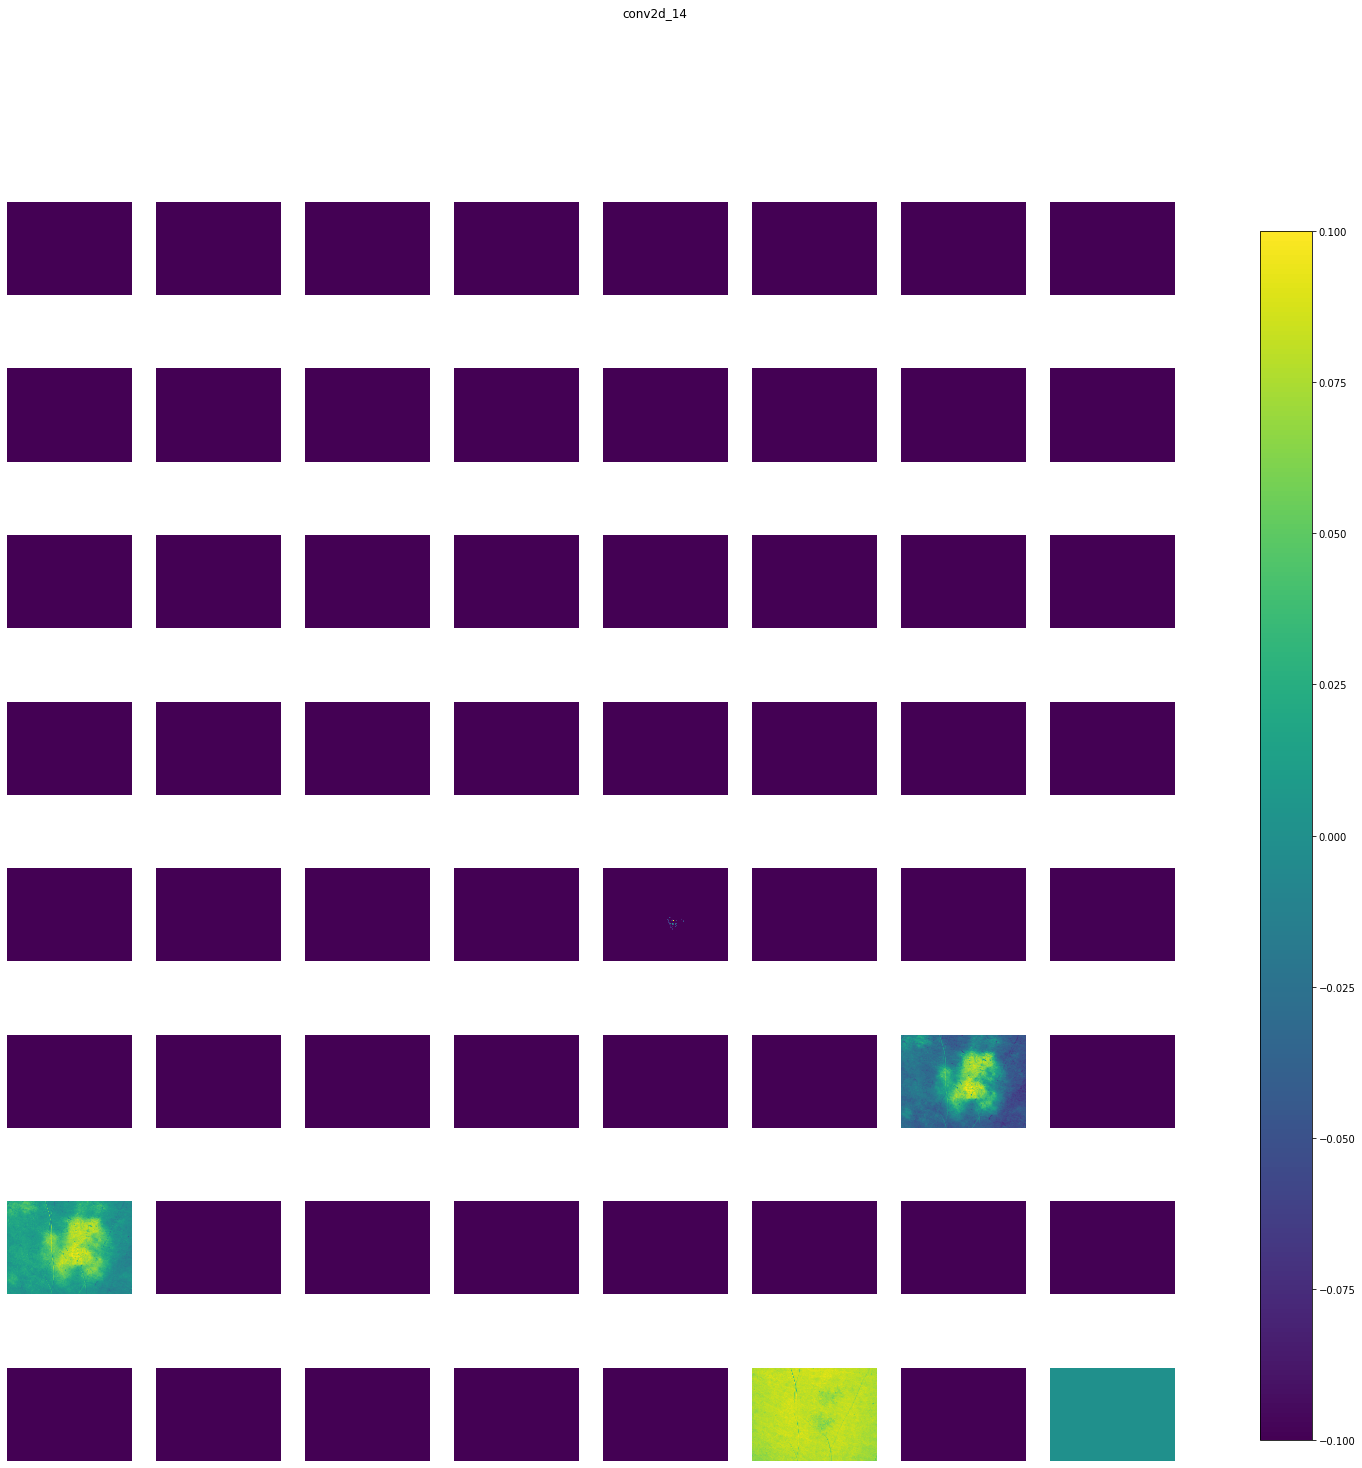

conv2d_1_2 (1, 450, 600, 64) 


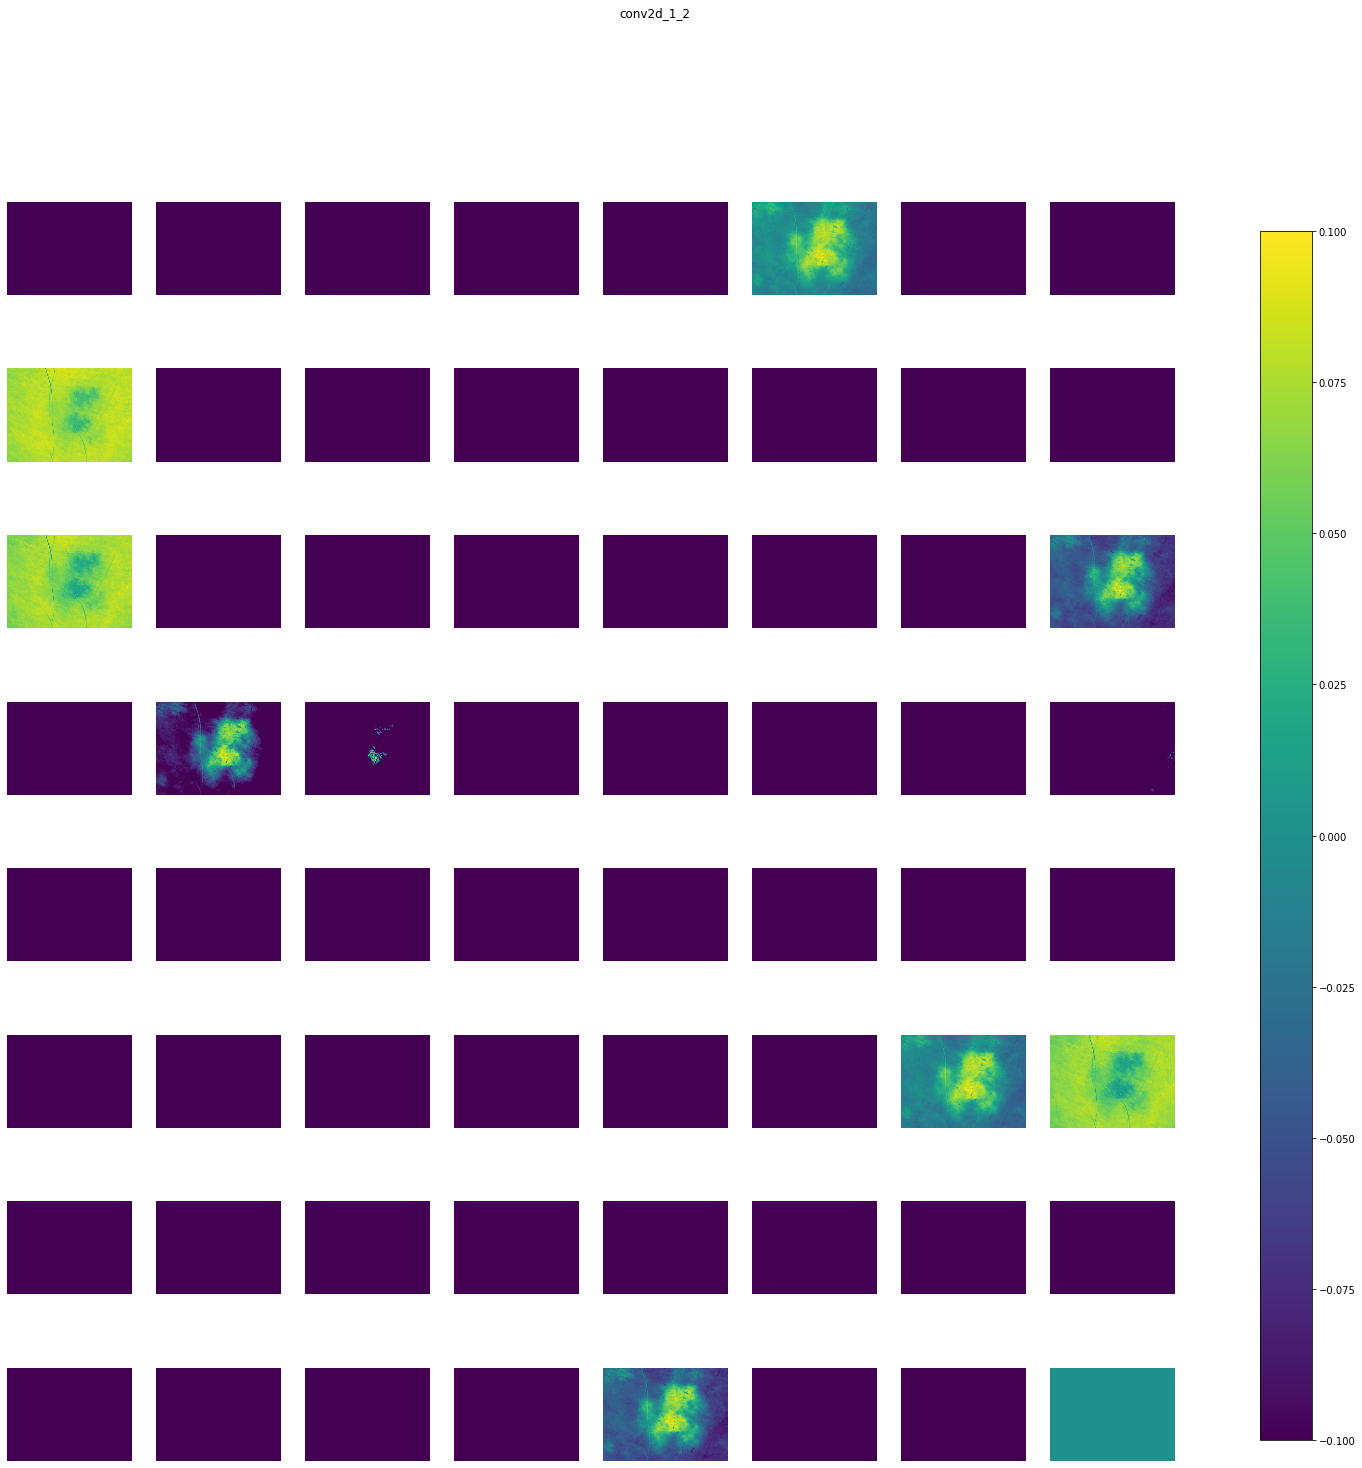

max_pooling2d_6 (1, 225, 300, 64) 


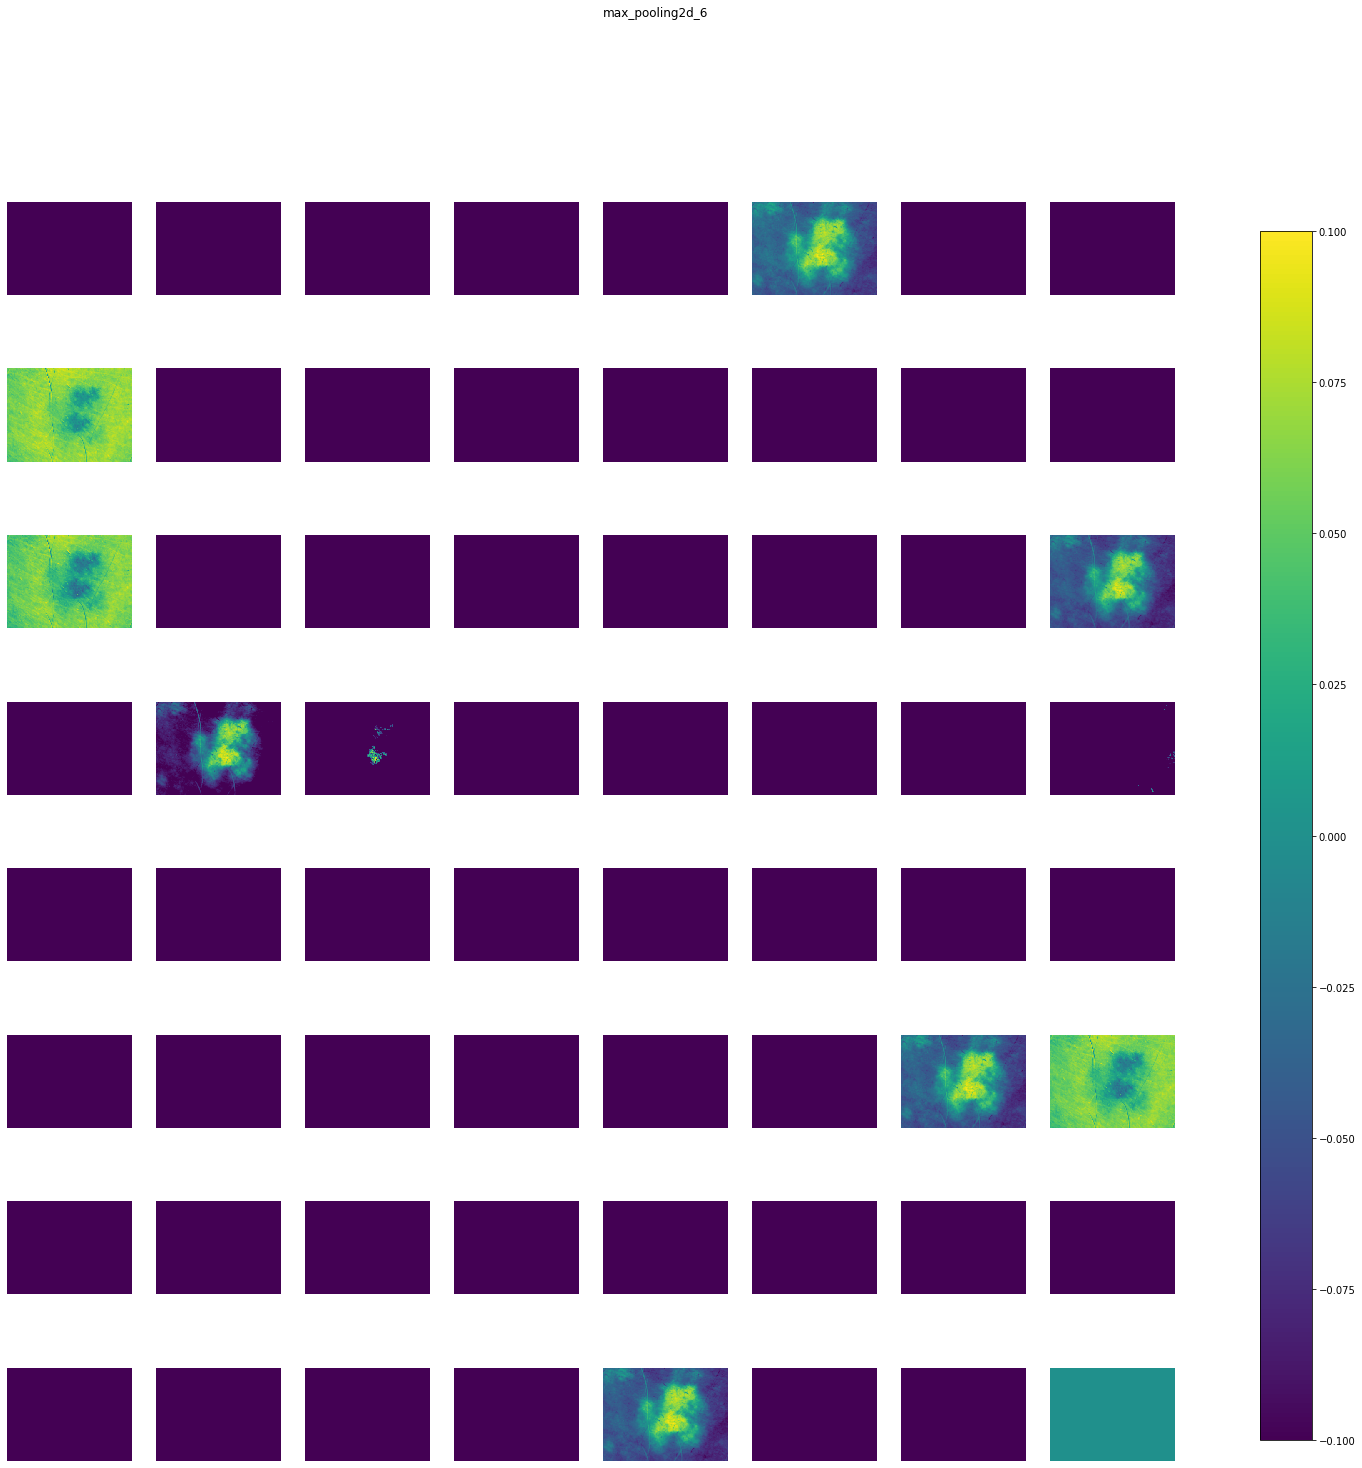

conv2d_2_2 (1, 225, 300, 128) 


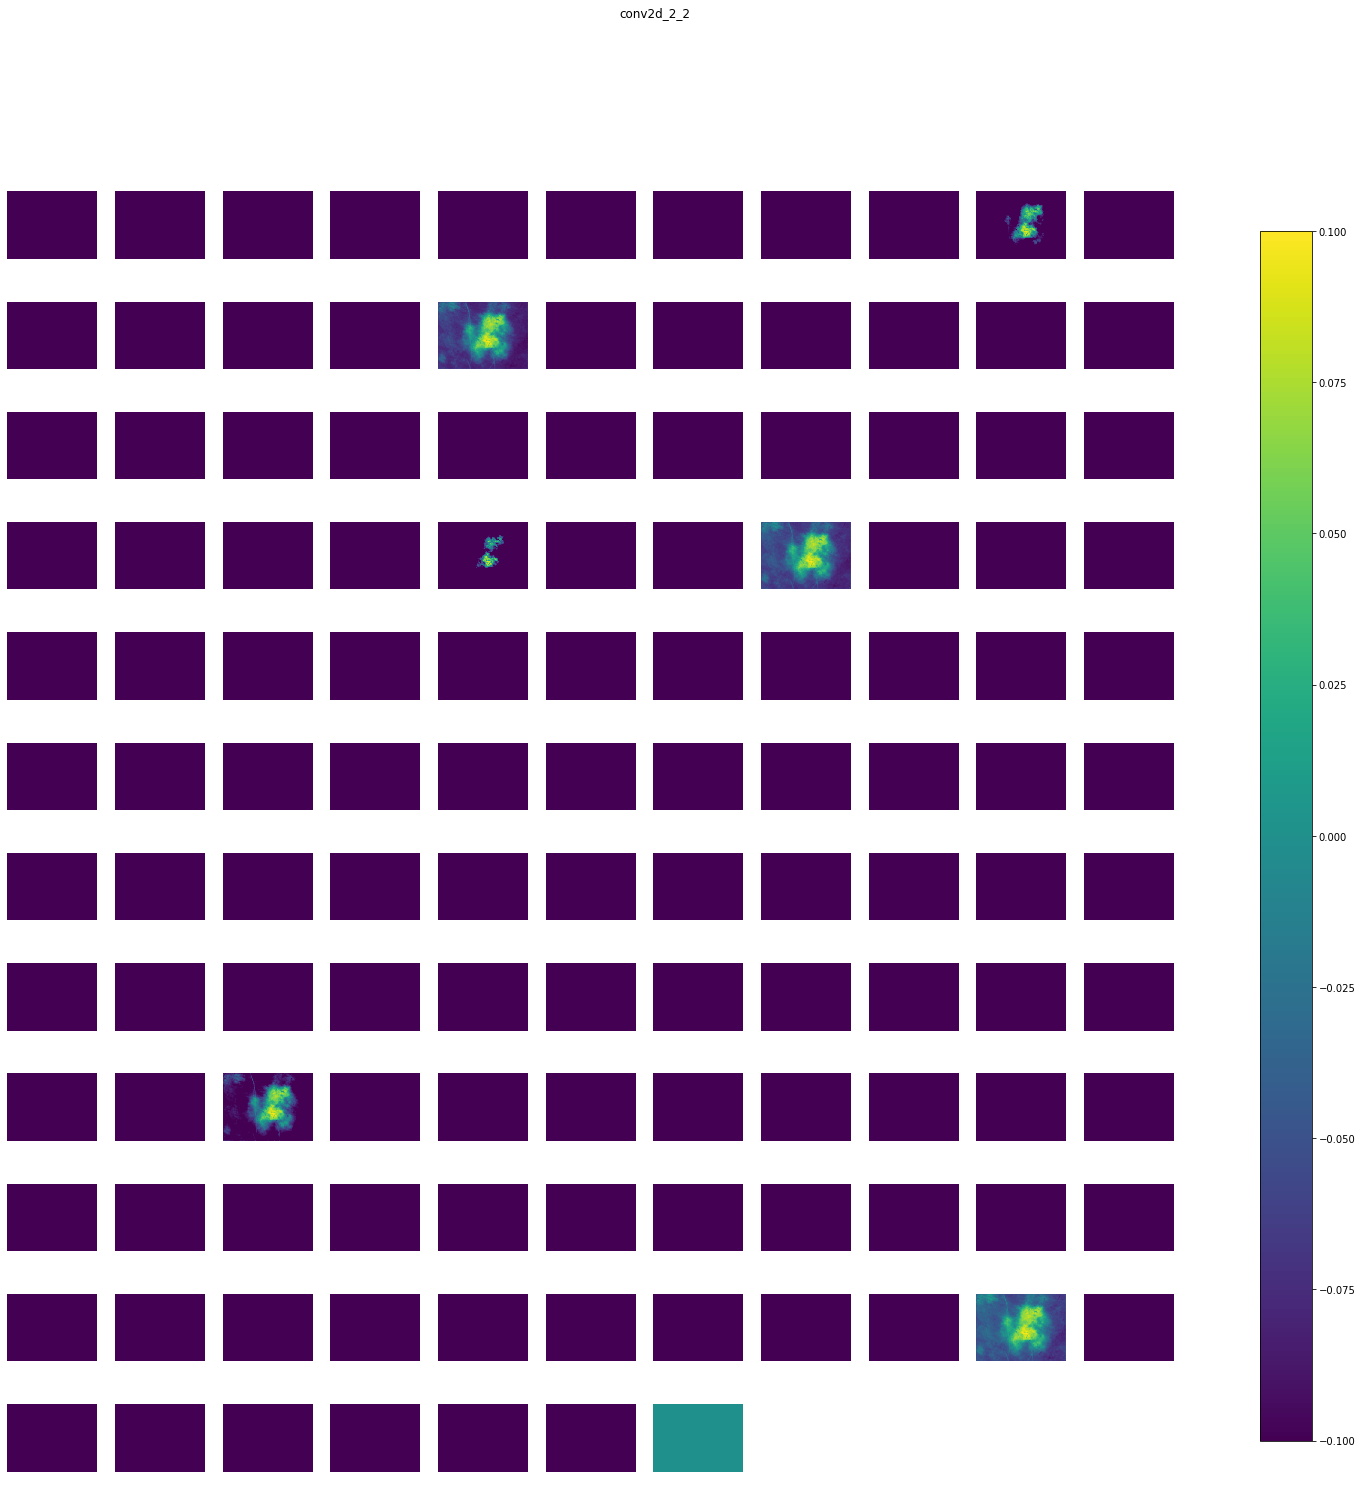

conv2d_3_2 (1, 225, 300, 128) 


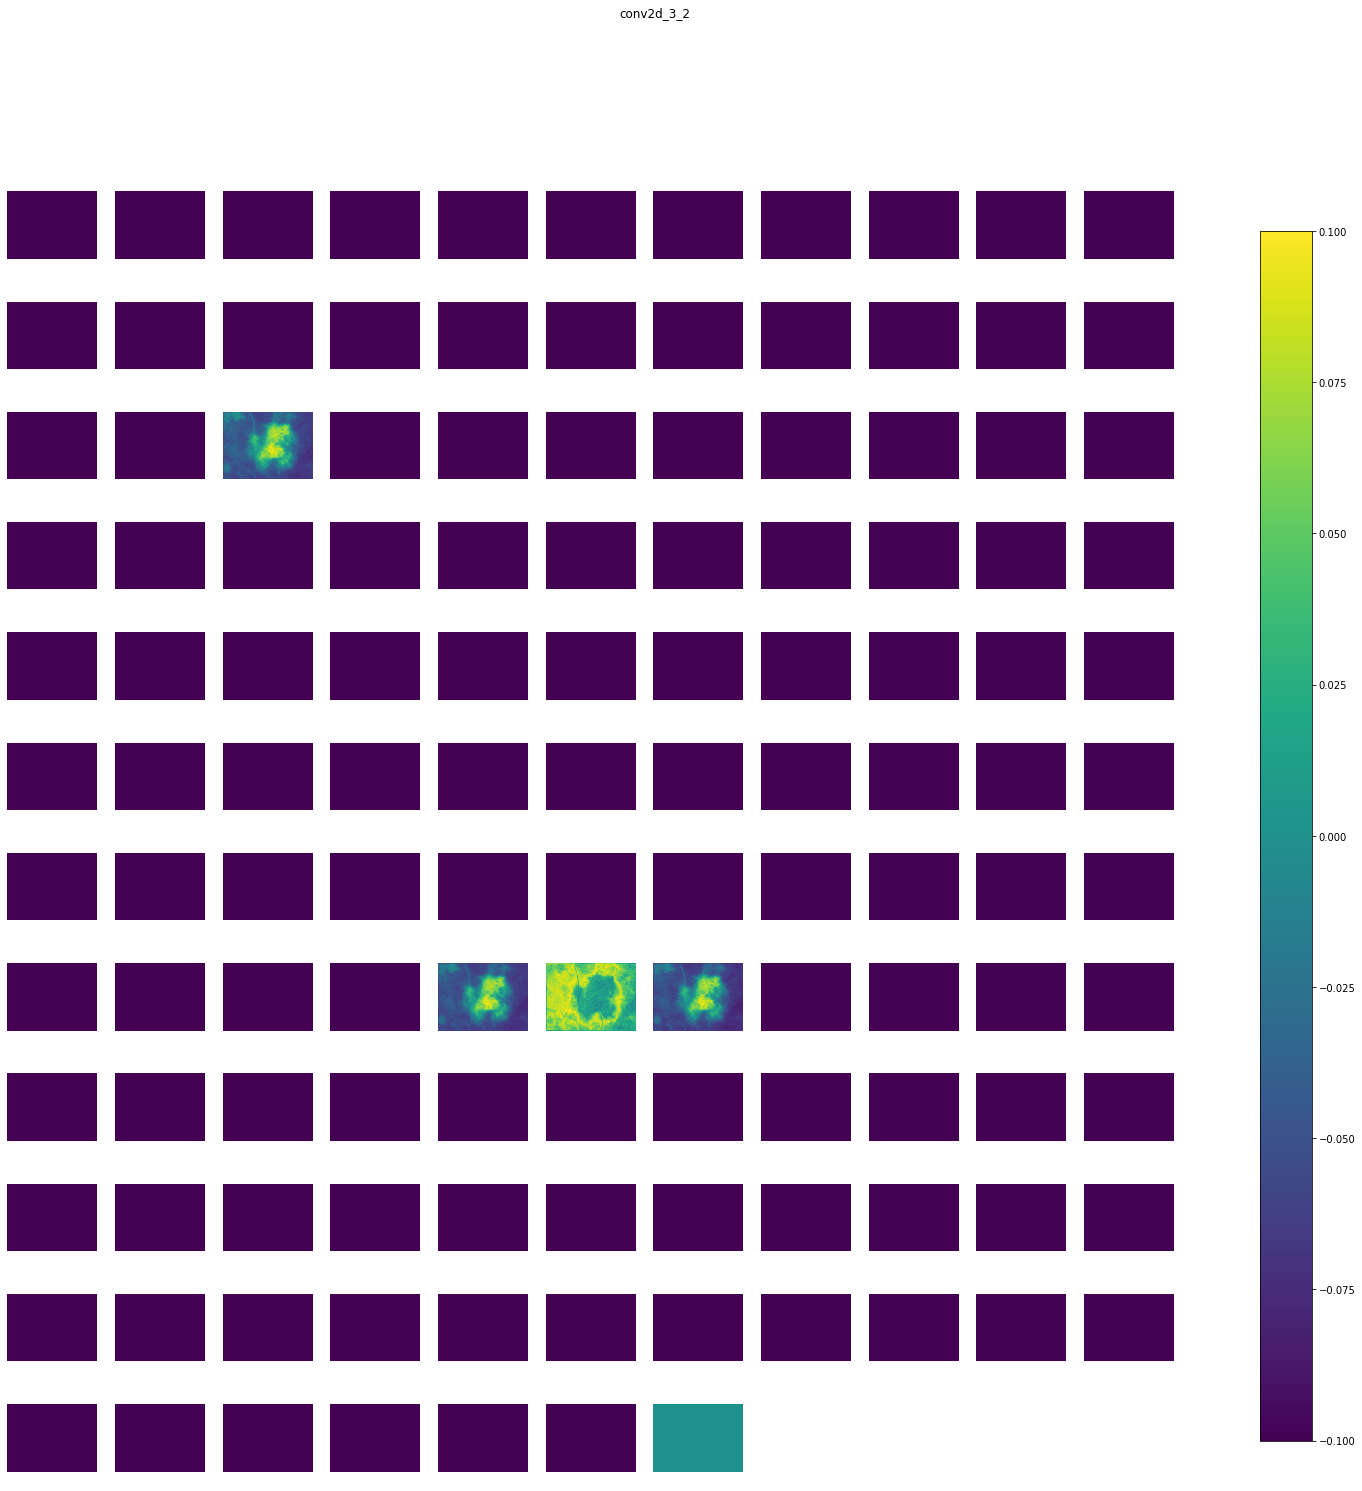

max_pooling2d_1_2 (1, 112, 150, 128) 


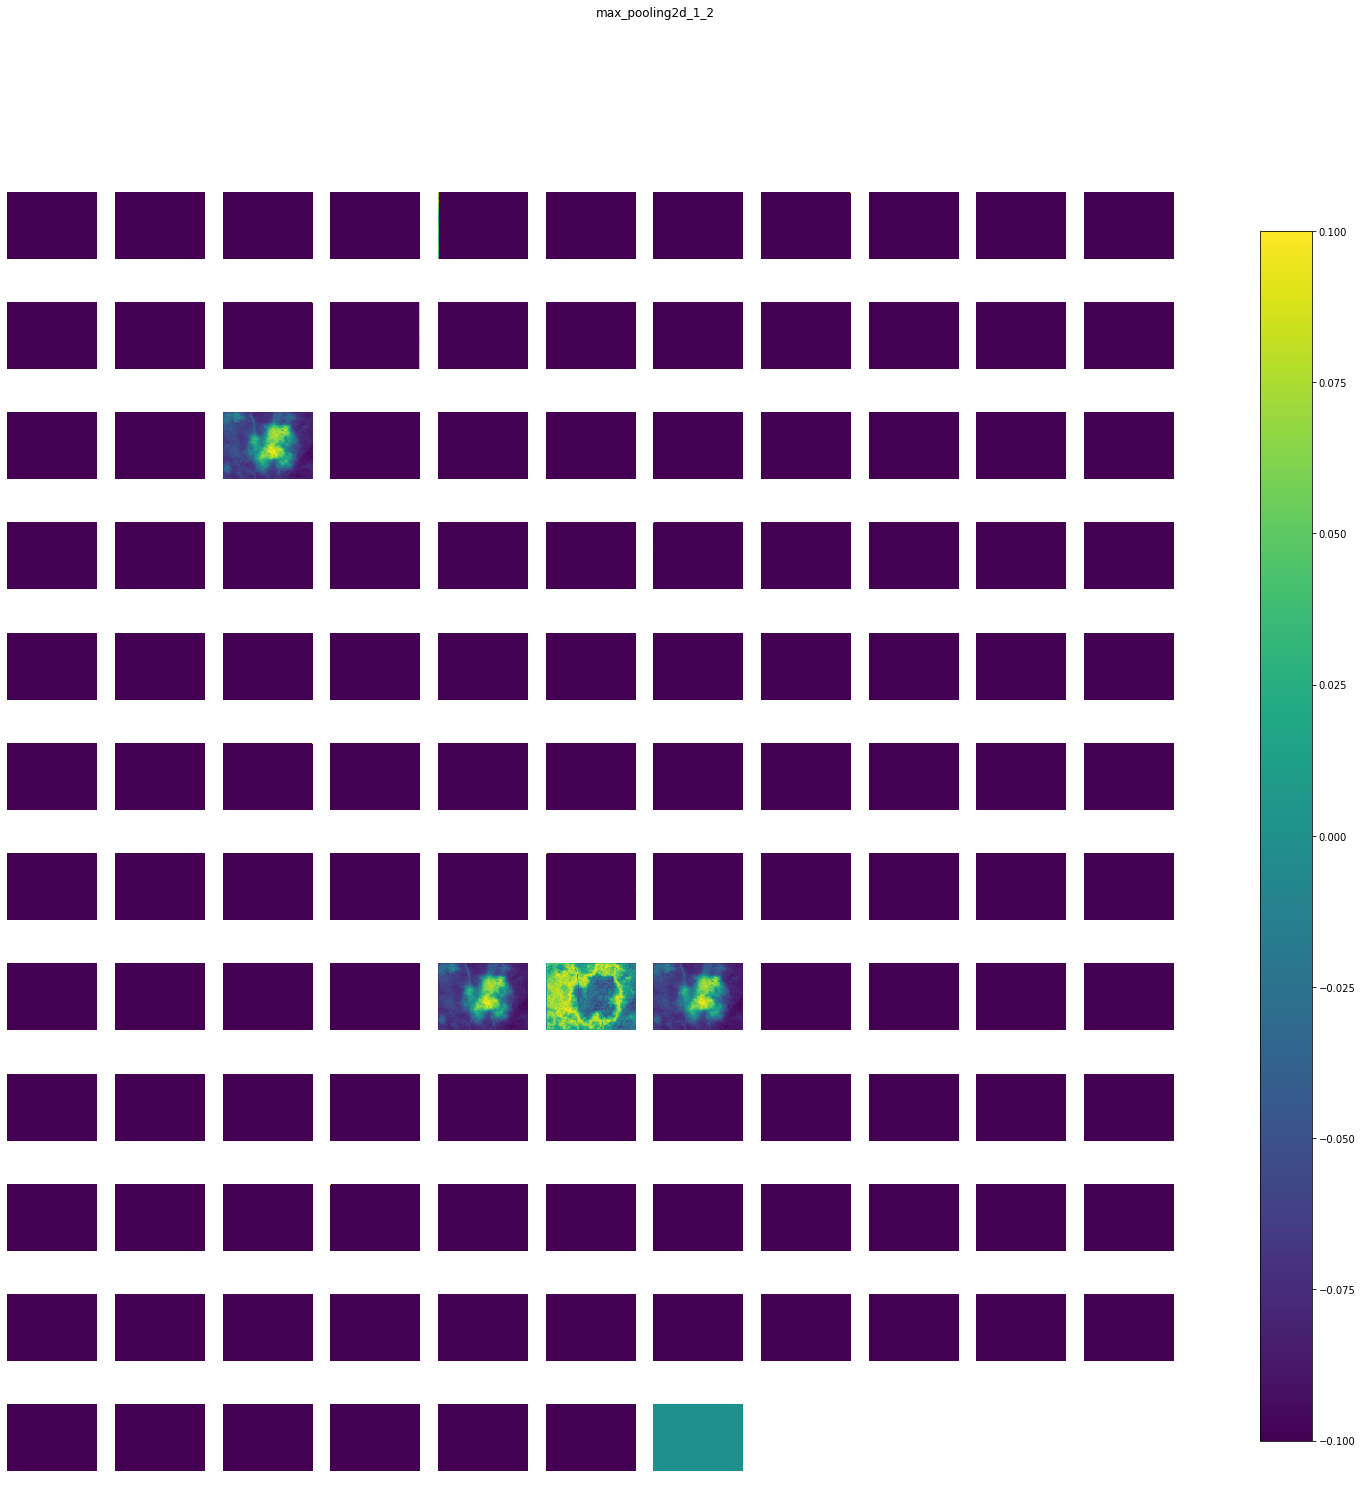

conv2d_4_2 (1, 112, 150, 128) 


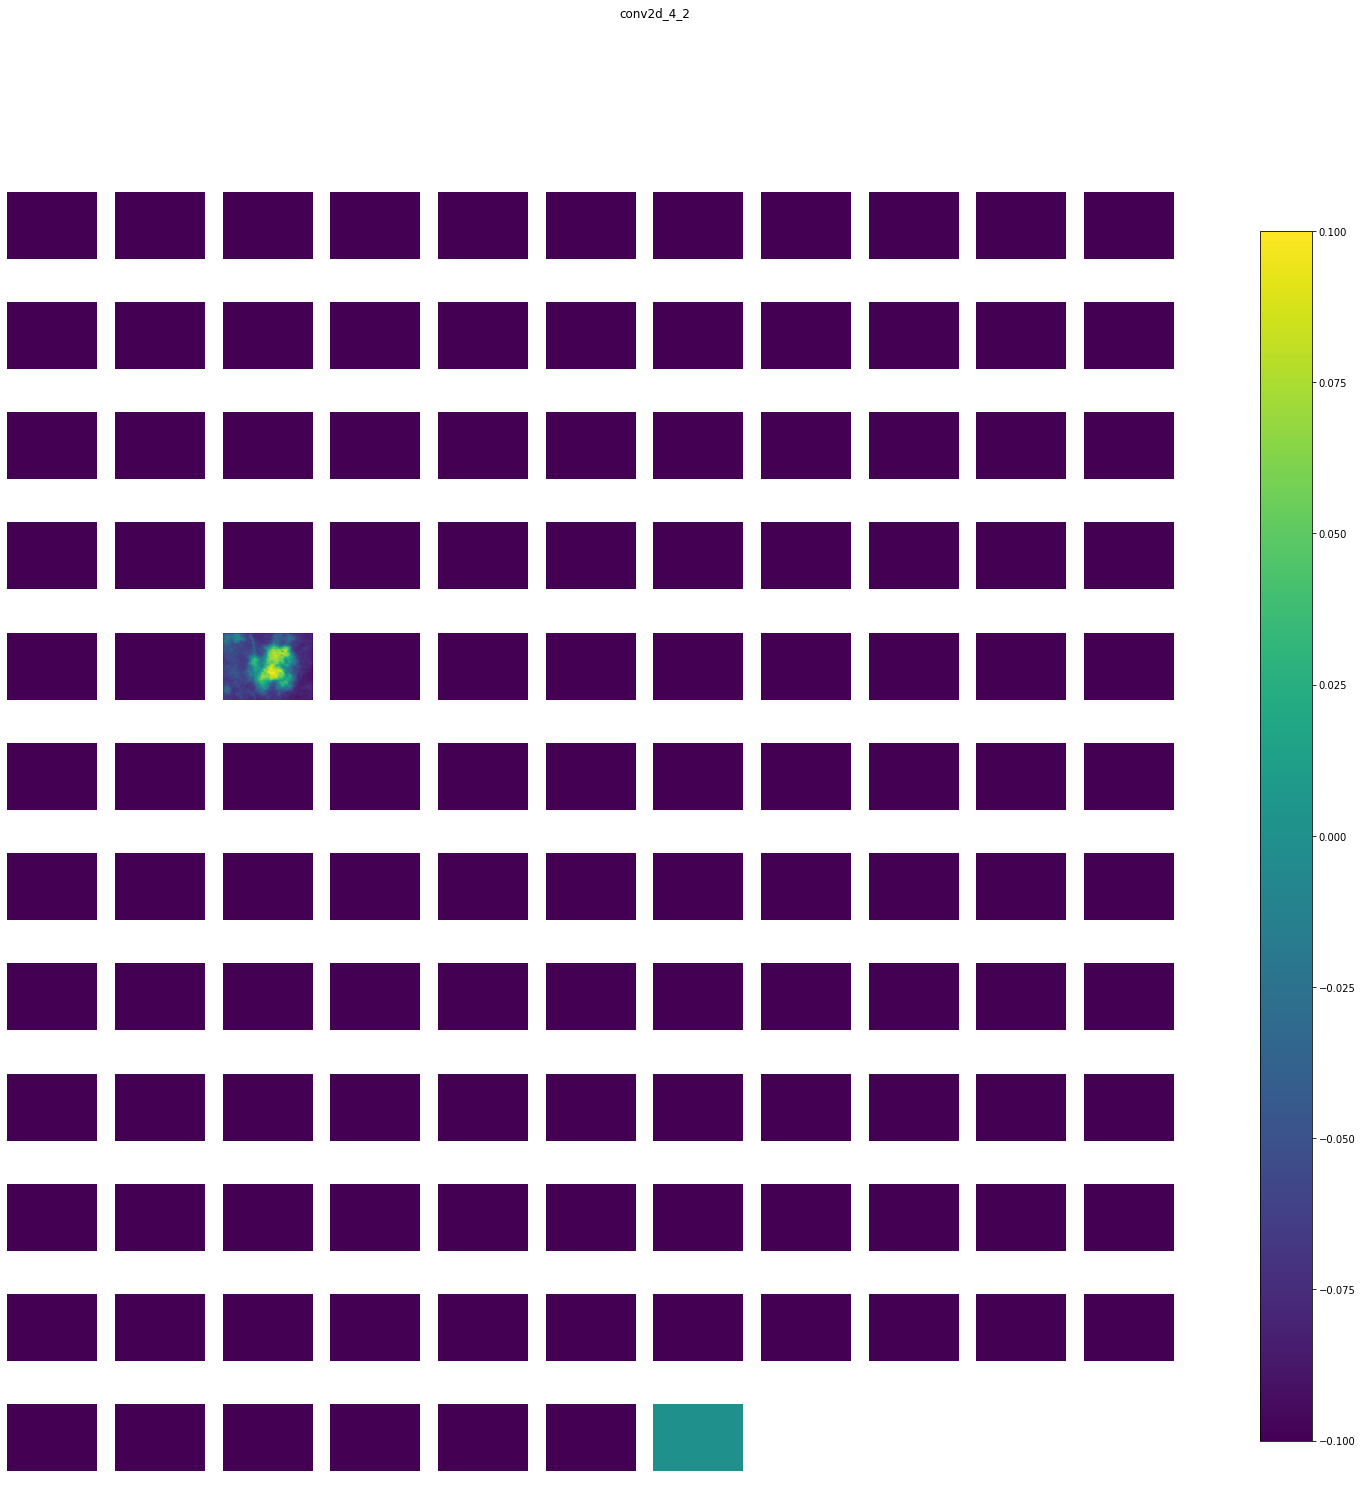

conv2d_5_2 (1, 112, 150, 128) 


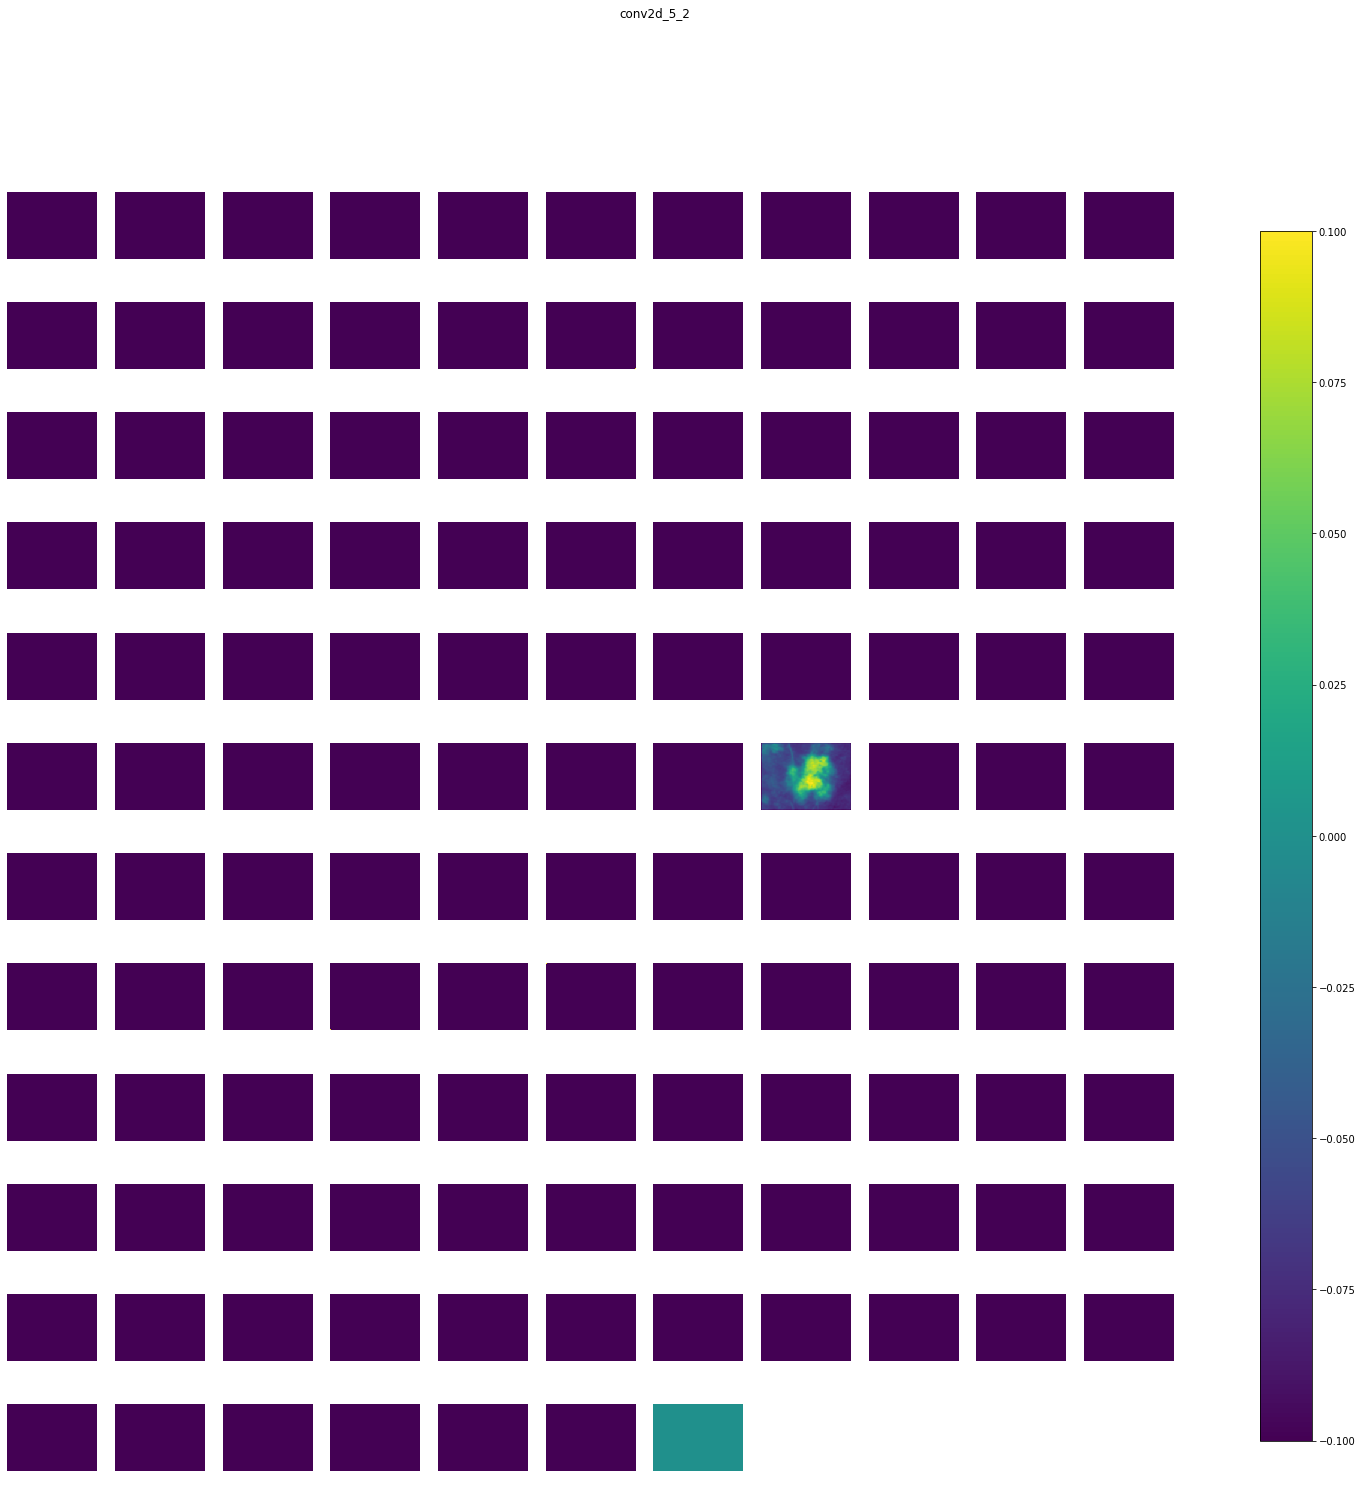

conv2d_6_2 (1, 112, 150, 128) 


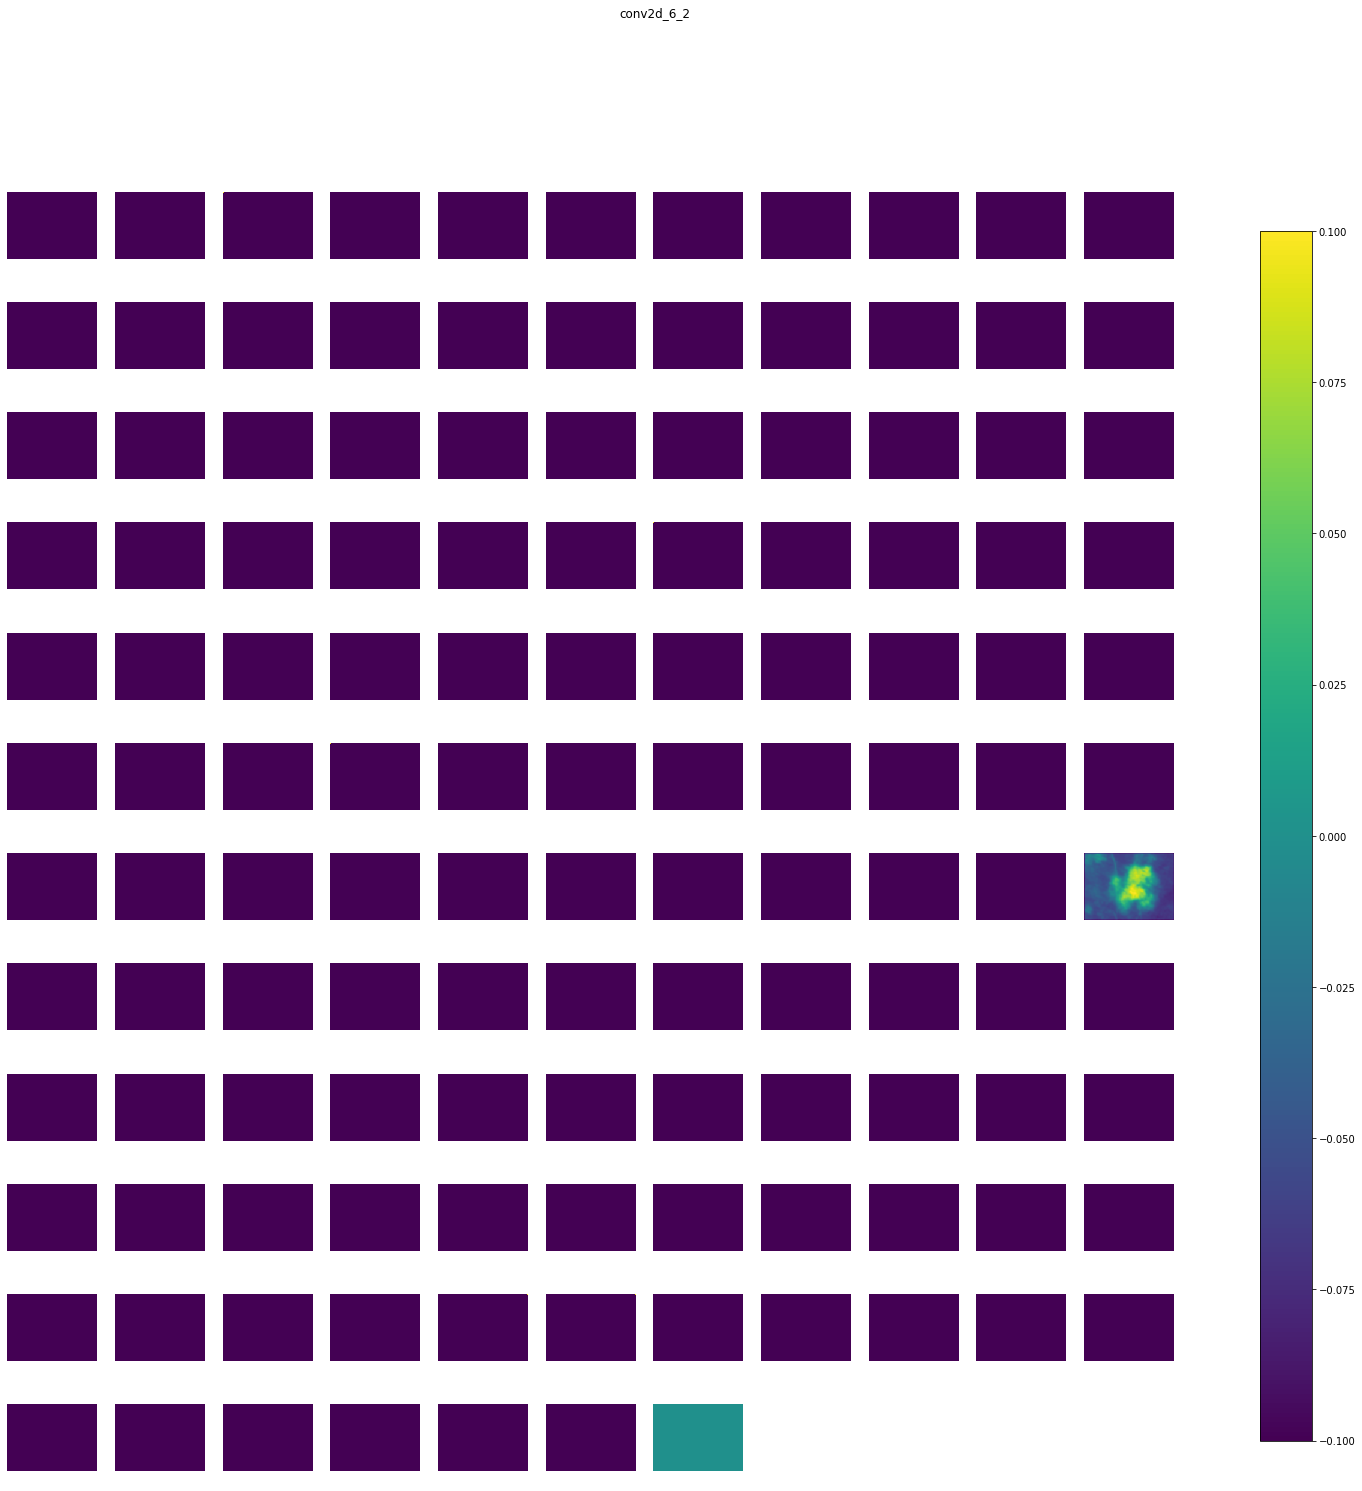

max_pooling2d_2_2 (1, 56, 75, 128) 


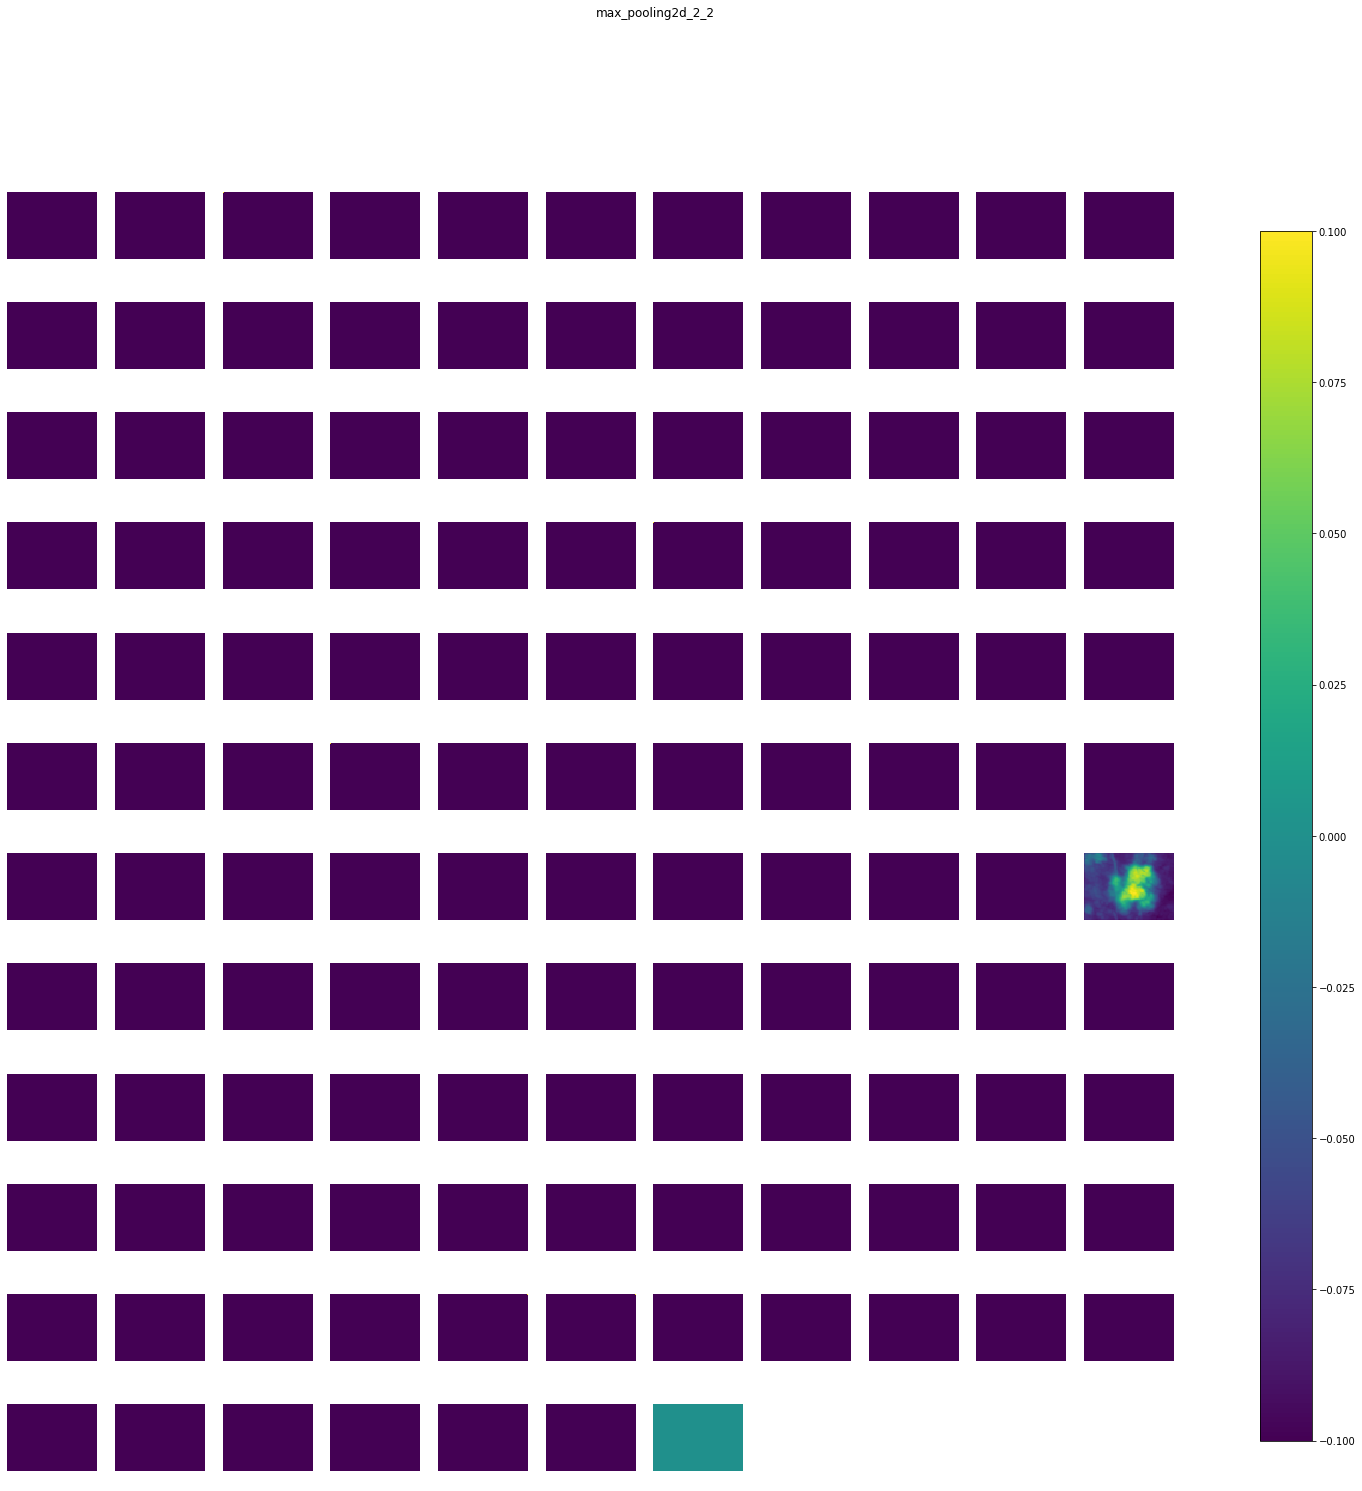

conv2d_7_2 (1, 56, 75, 128) 


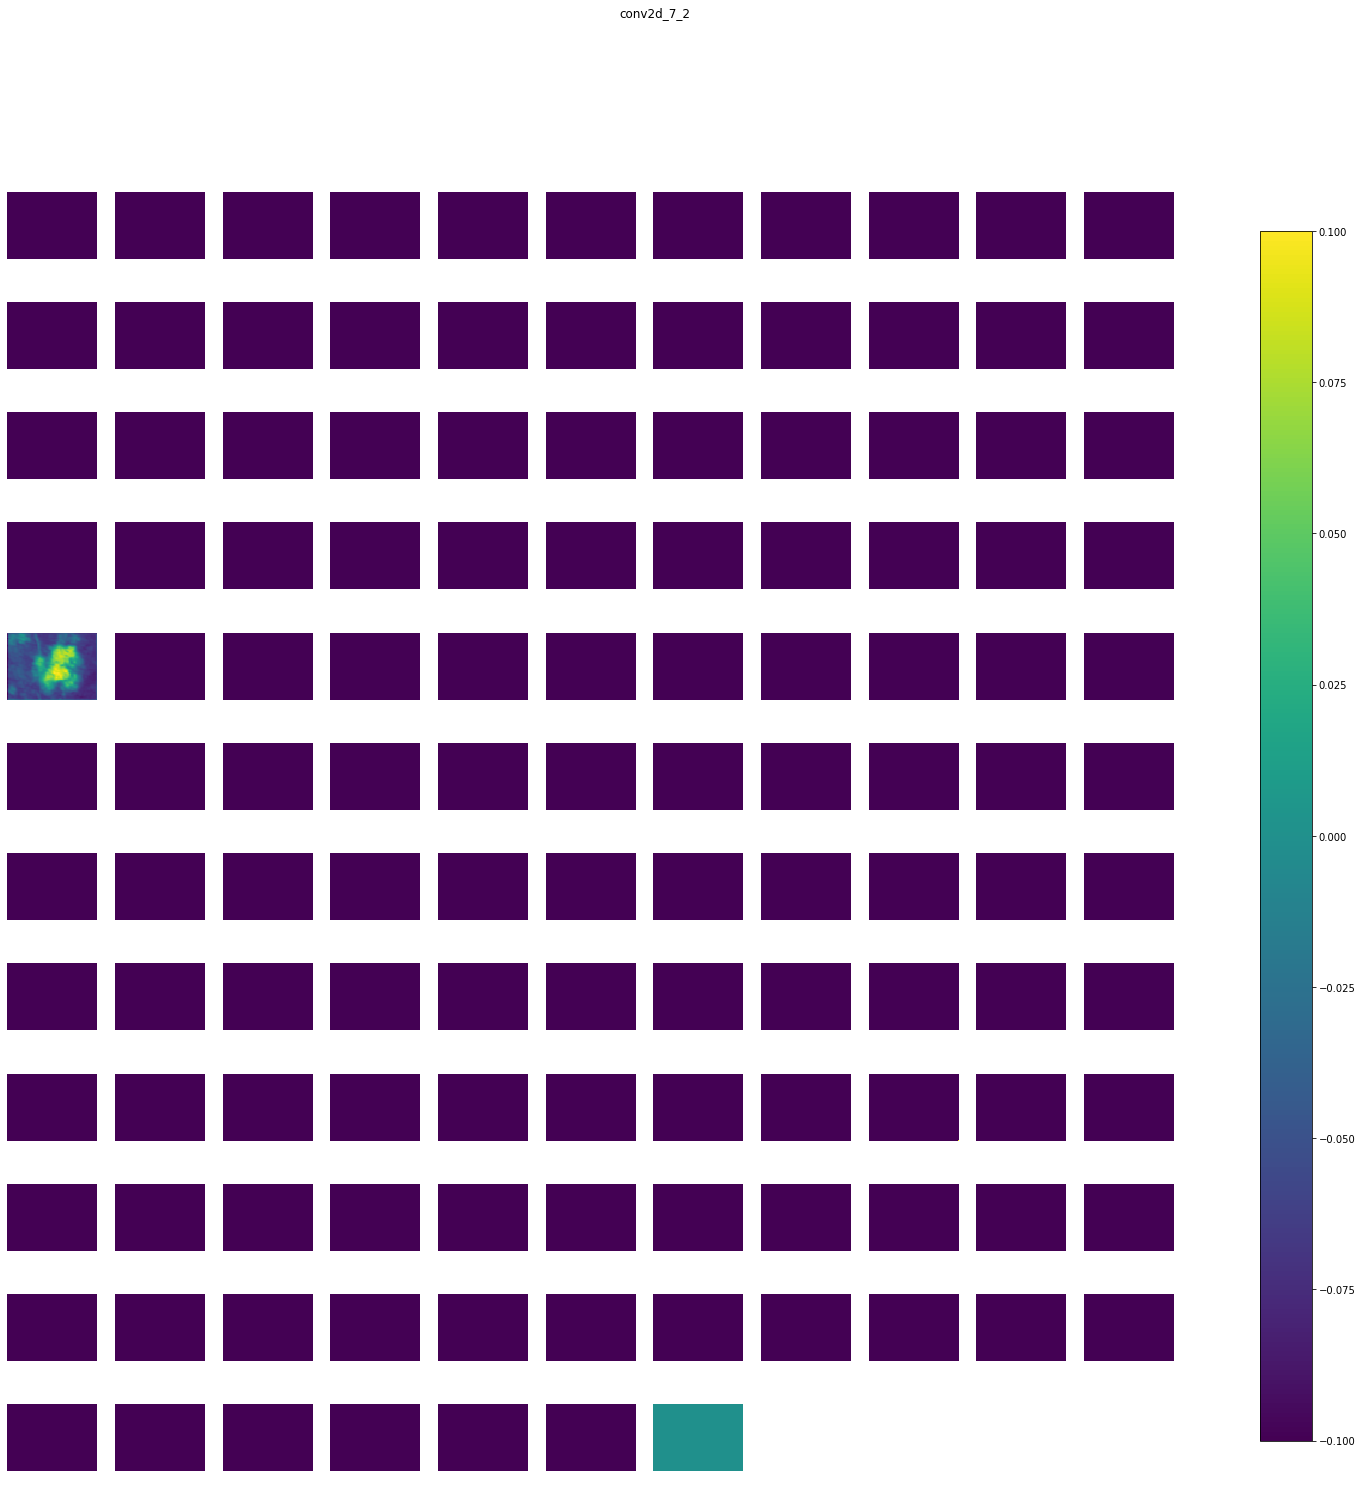

conv2d_8_2 (1, 56, 75, 128) 


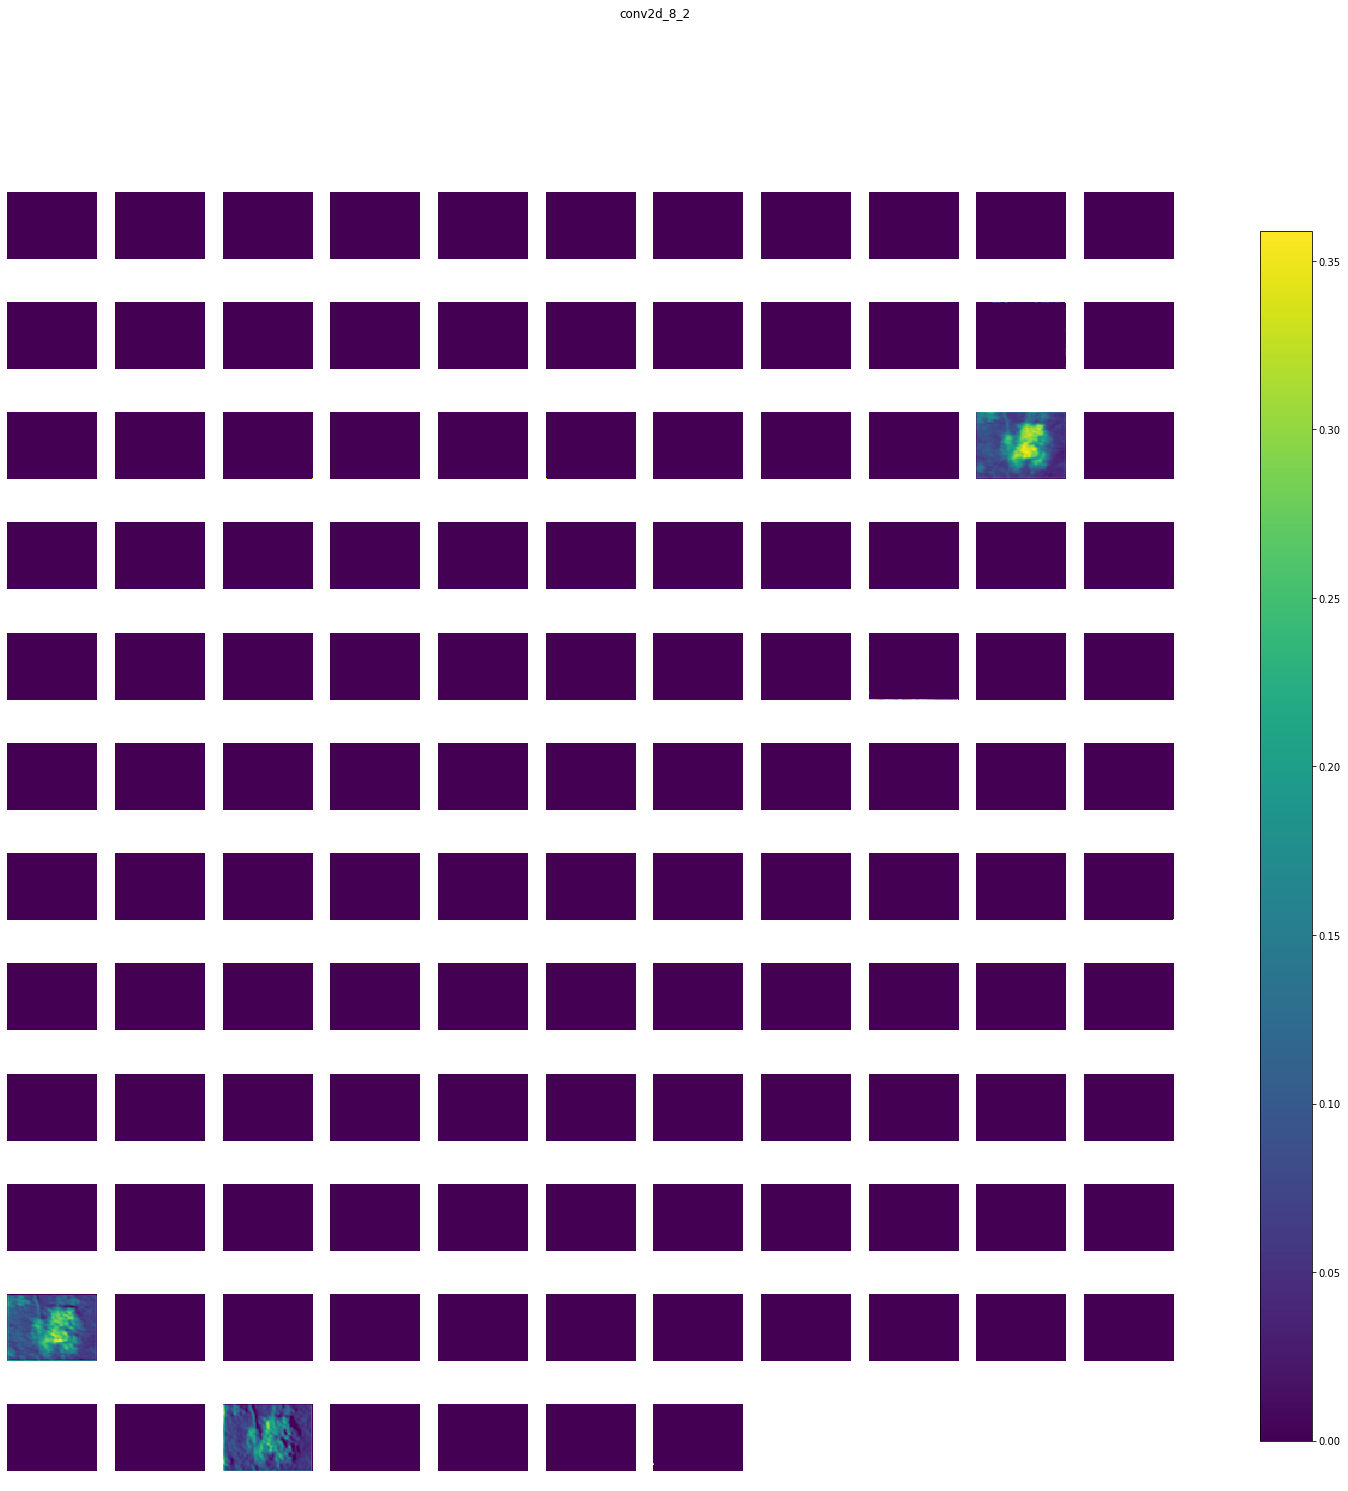

conv2d_9_2 (1, 56, 75, 128) 


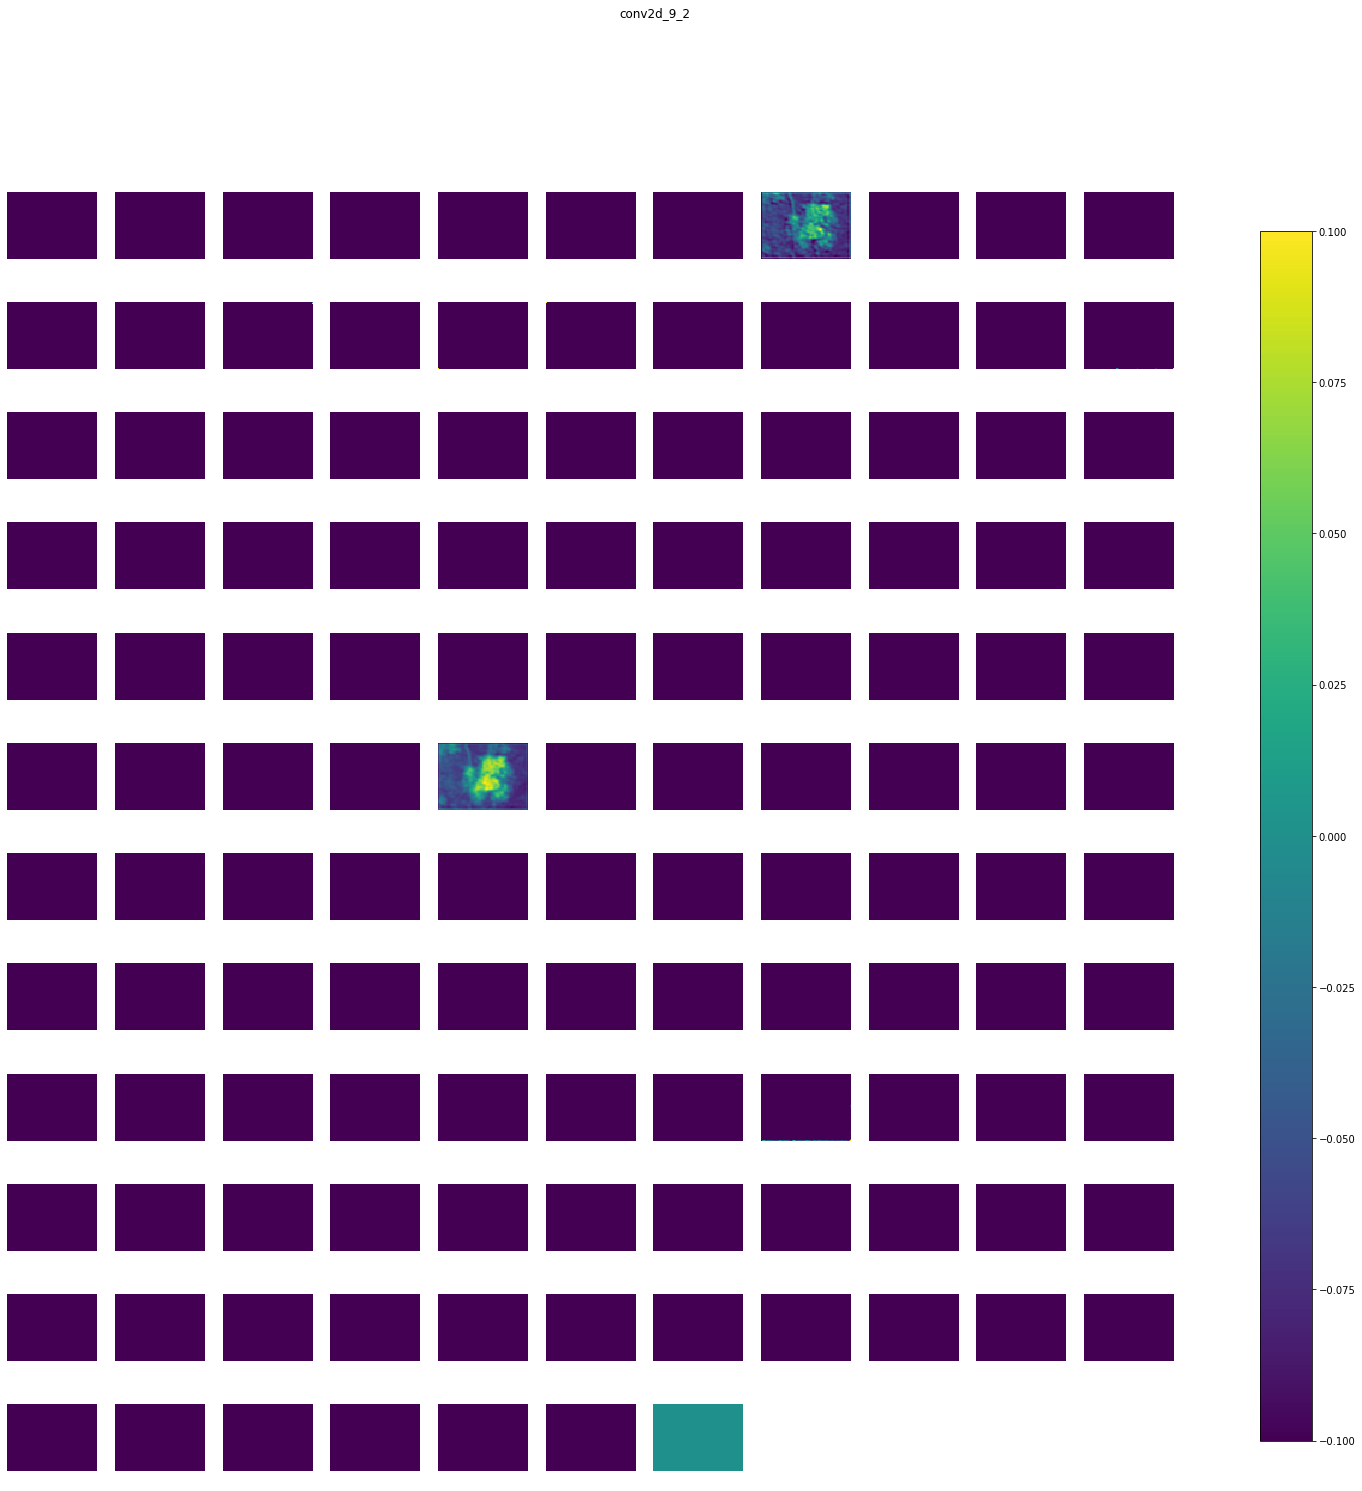

max_pooling2d_3_2 (1, 28, 37, 128) 


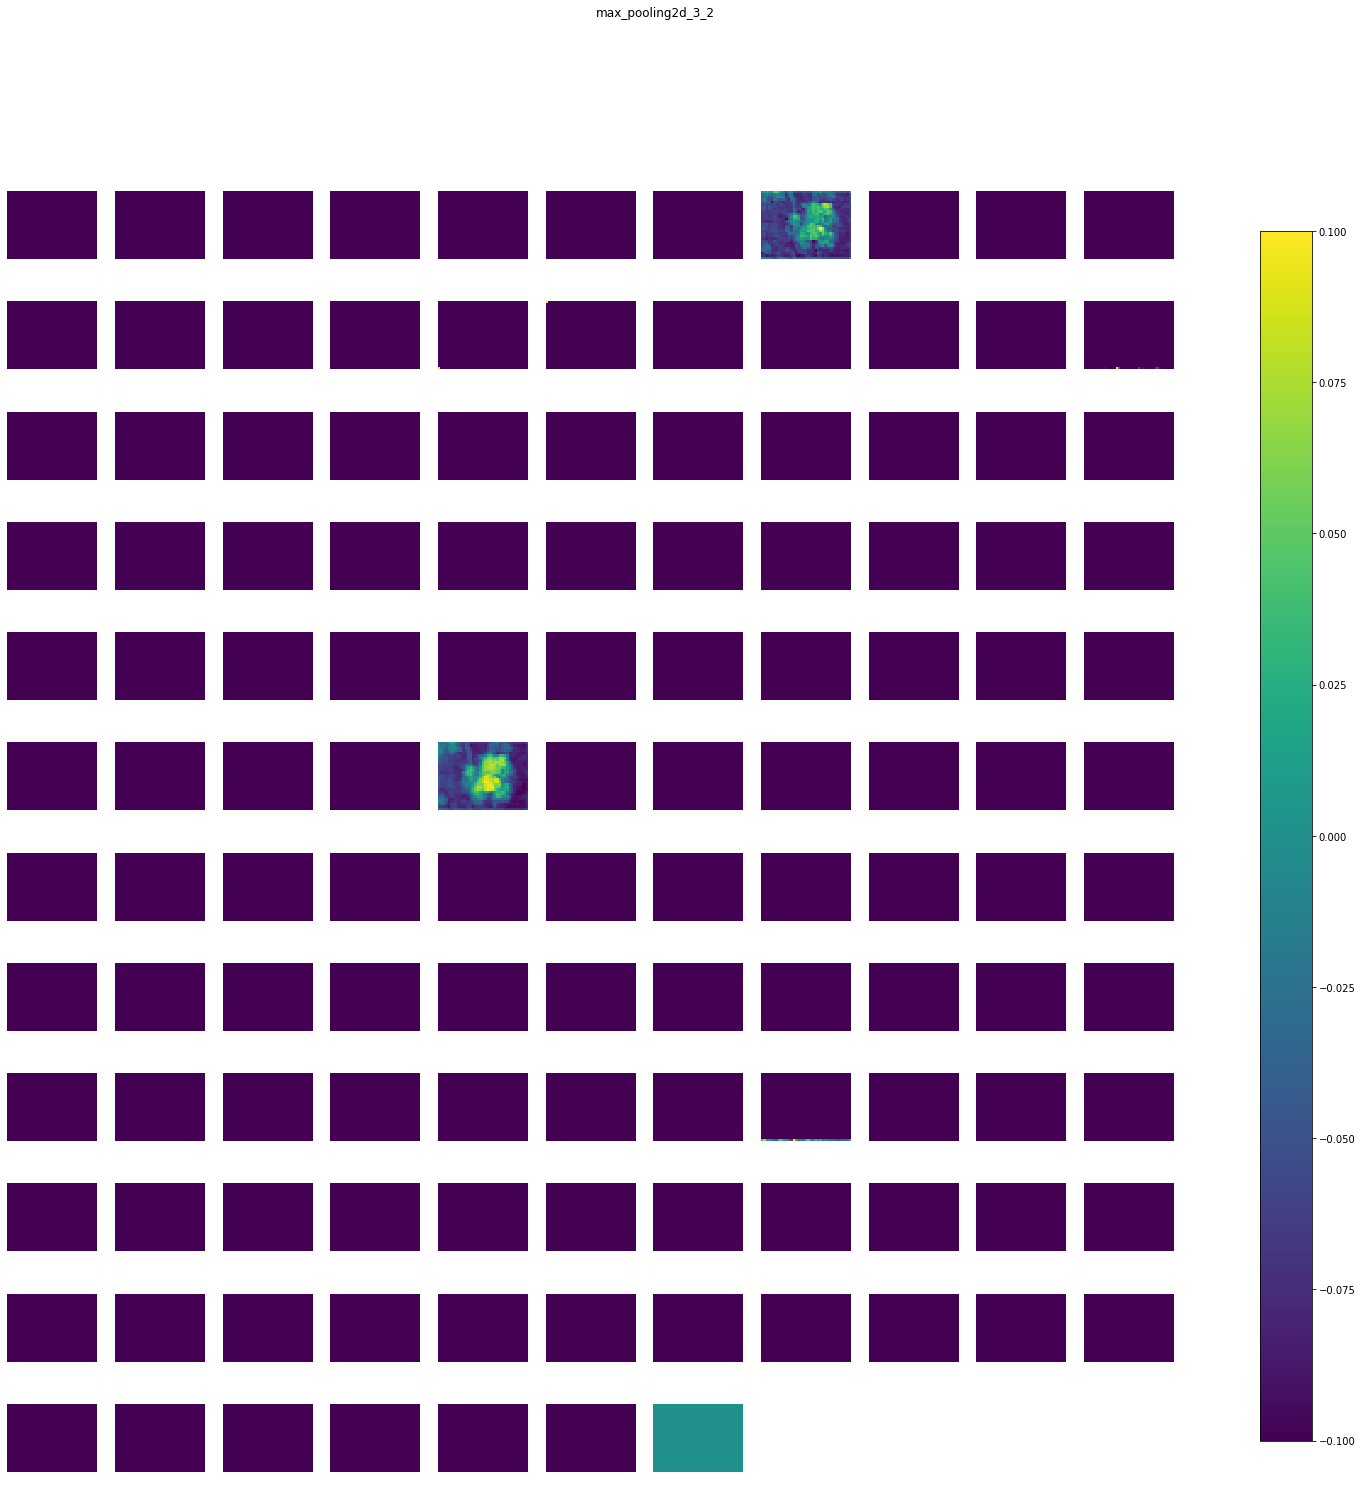

conv2d_10_2 (1, 28, 37, 256) 


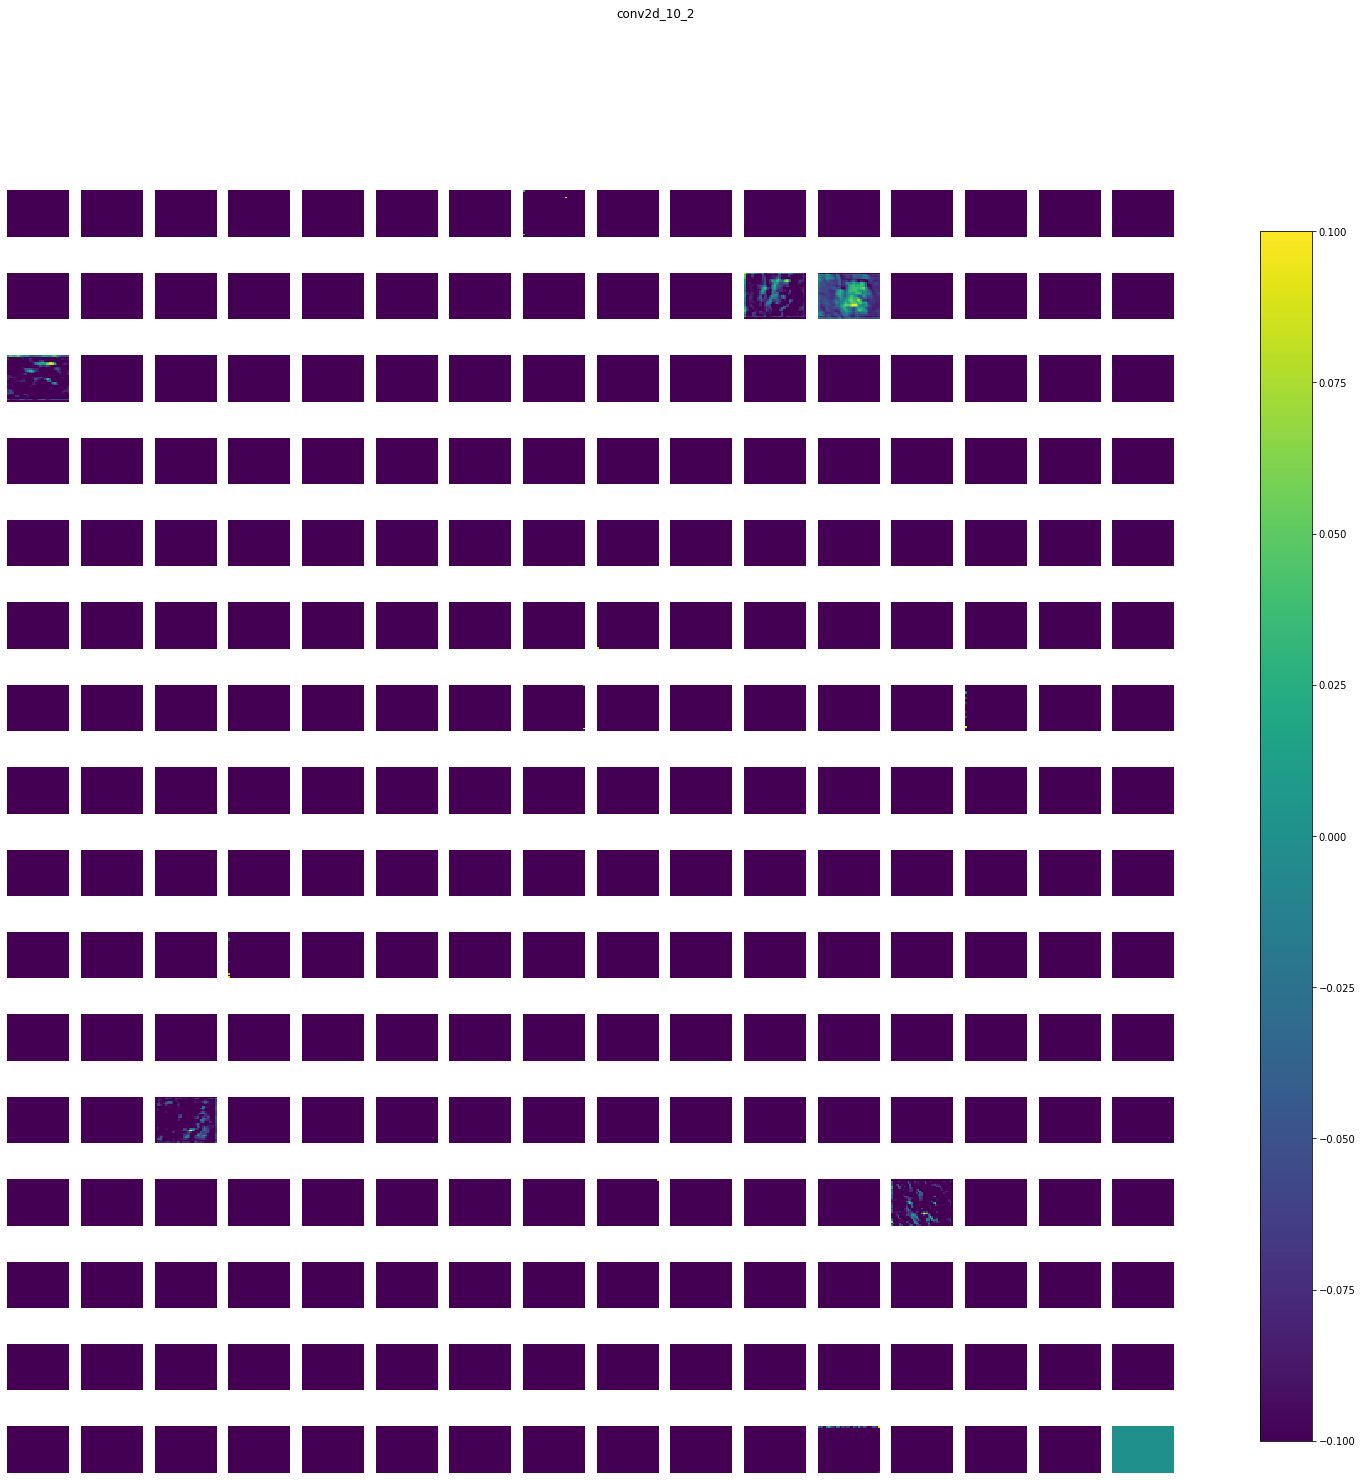

conv2d_11_2 (1, 28, 37, 256) 


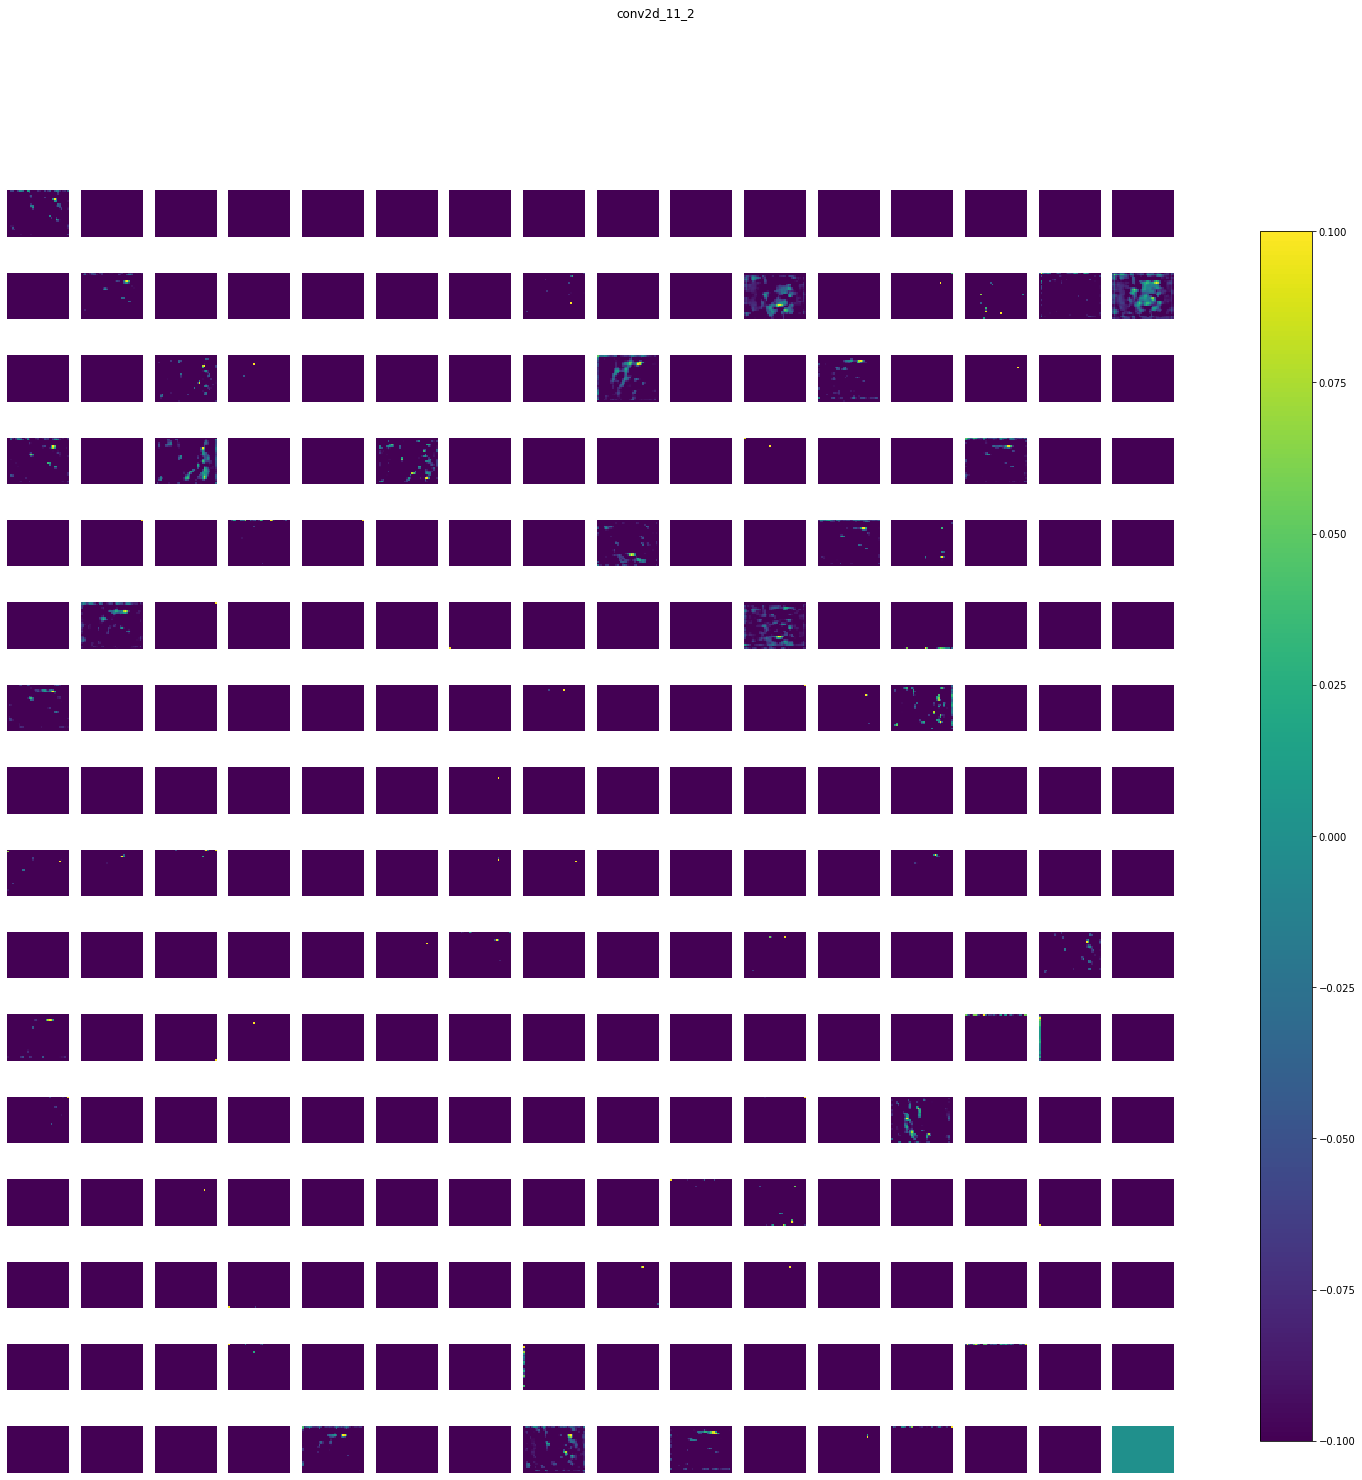

conv2d_12_2 (1, 28, 37, 256) 


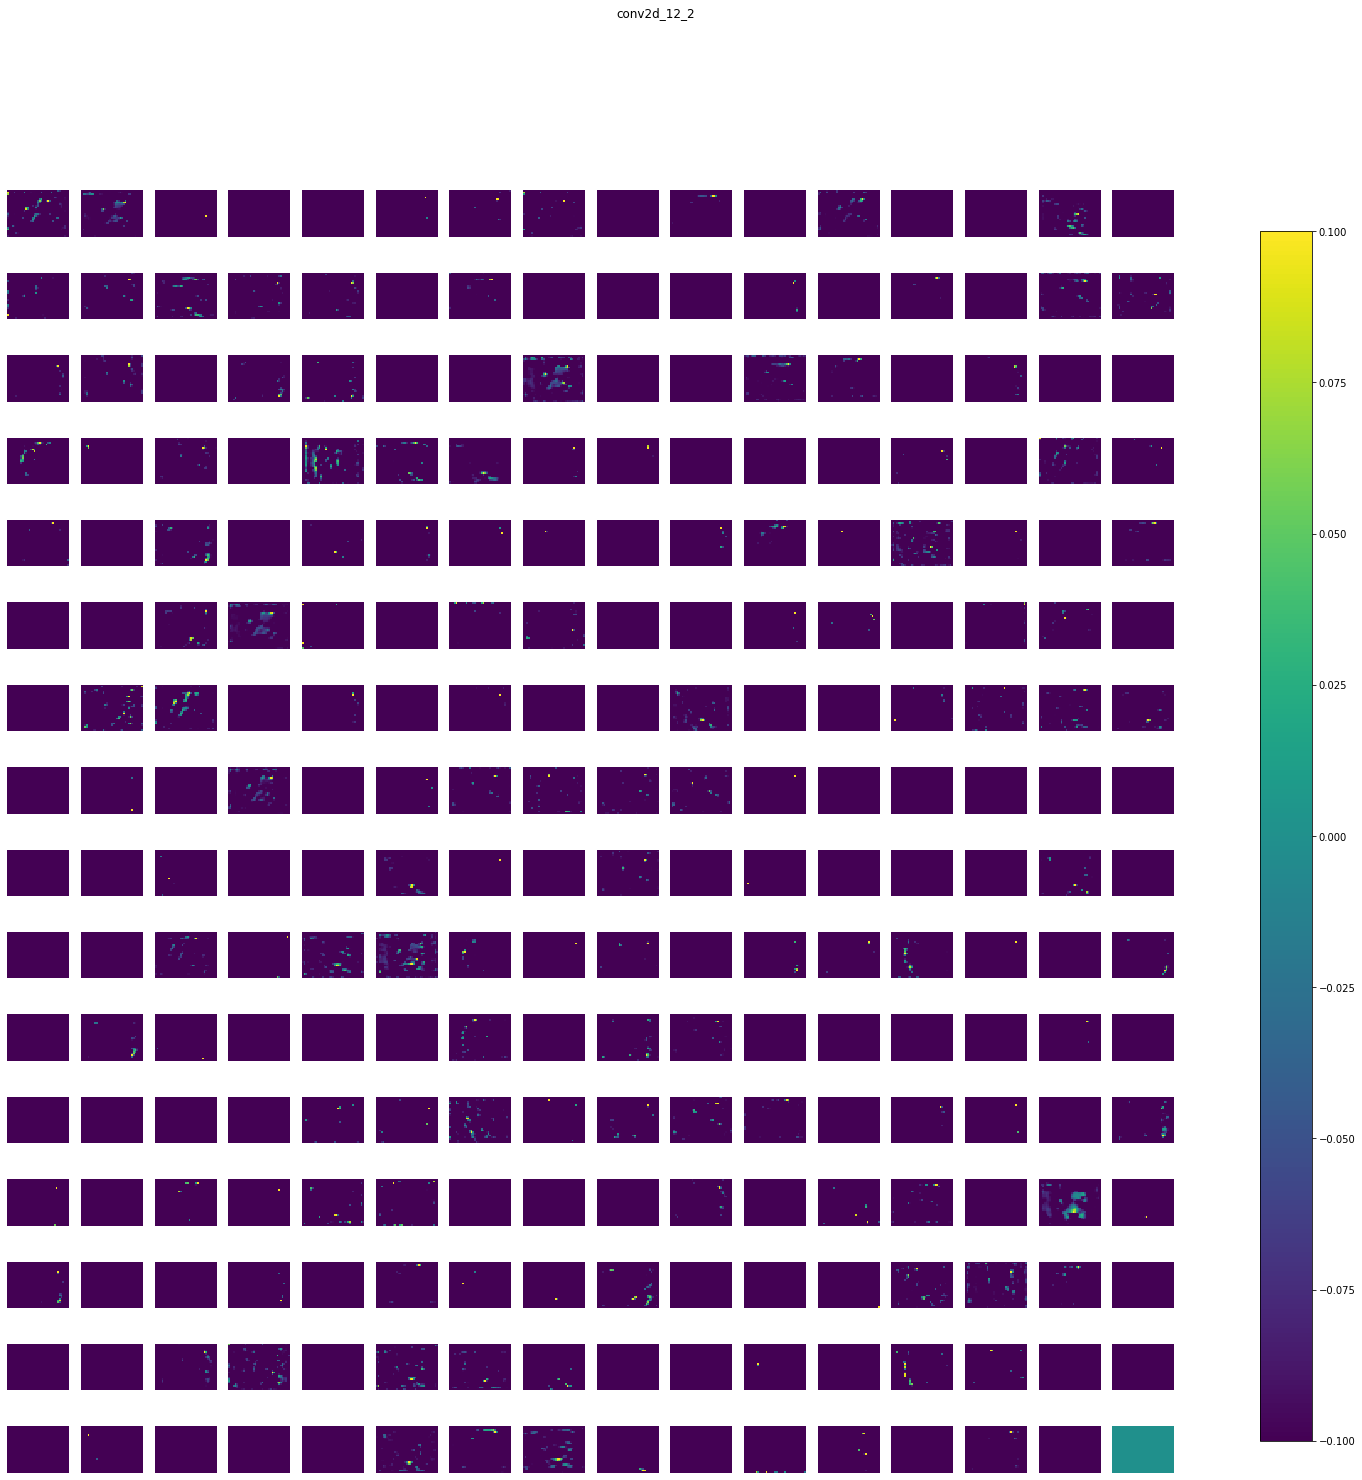

max_pooling2d_4_2 (1, 14, 18, 256) 


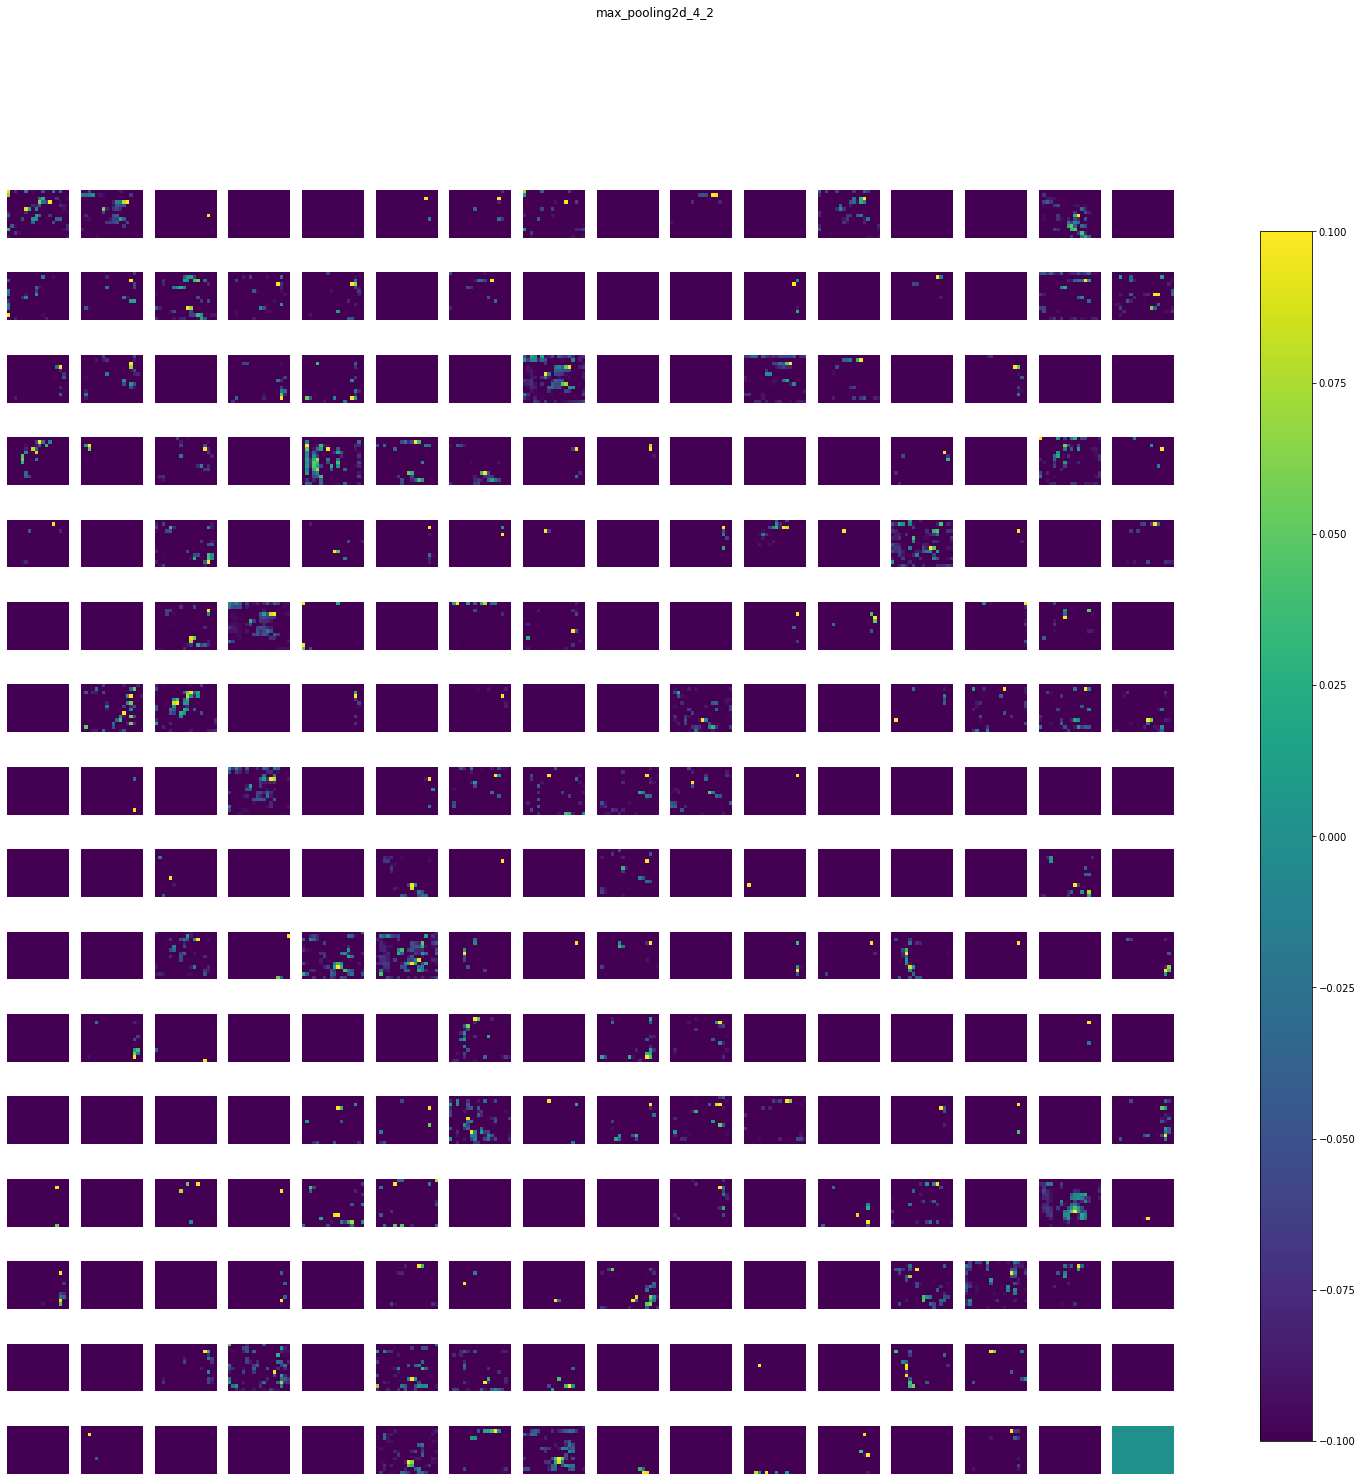

flatten_2 (1, 64512) 


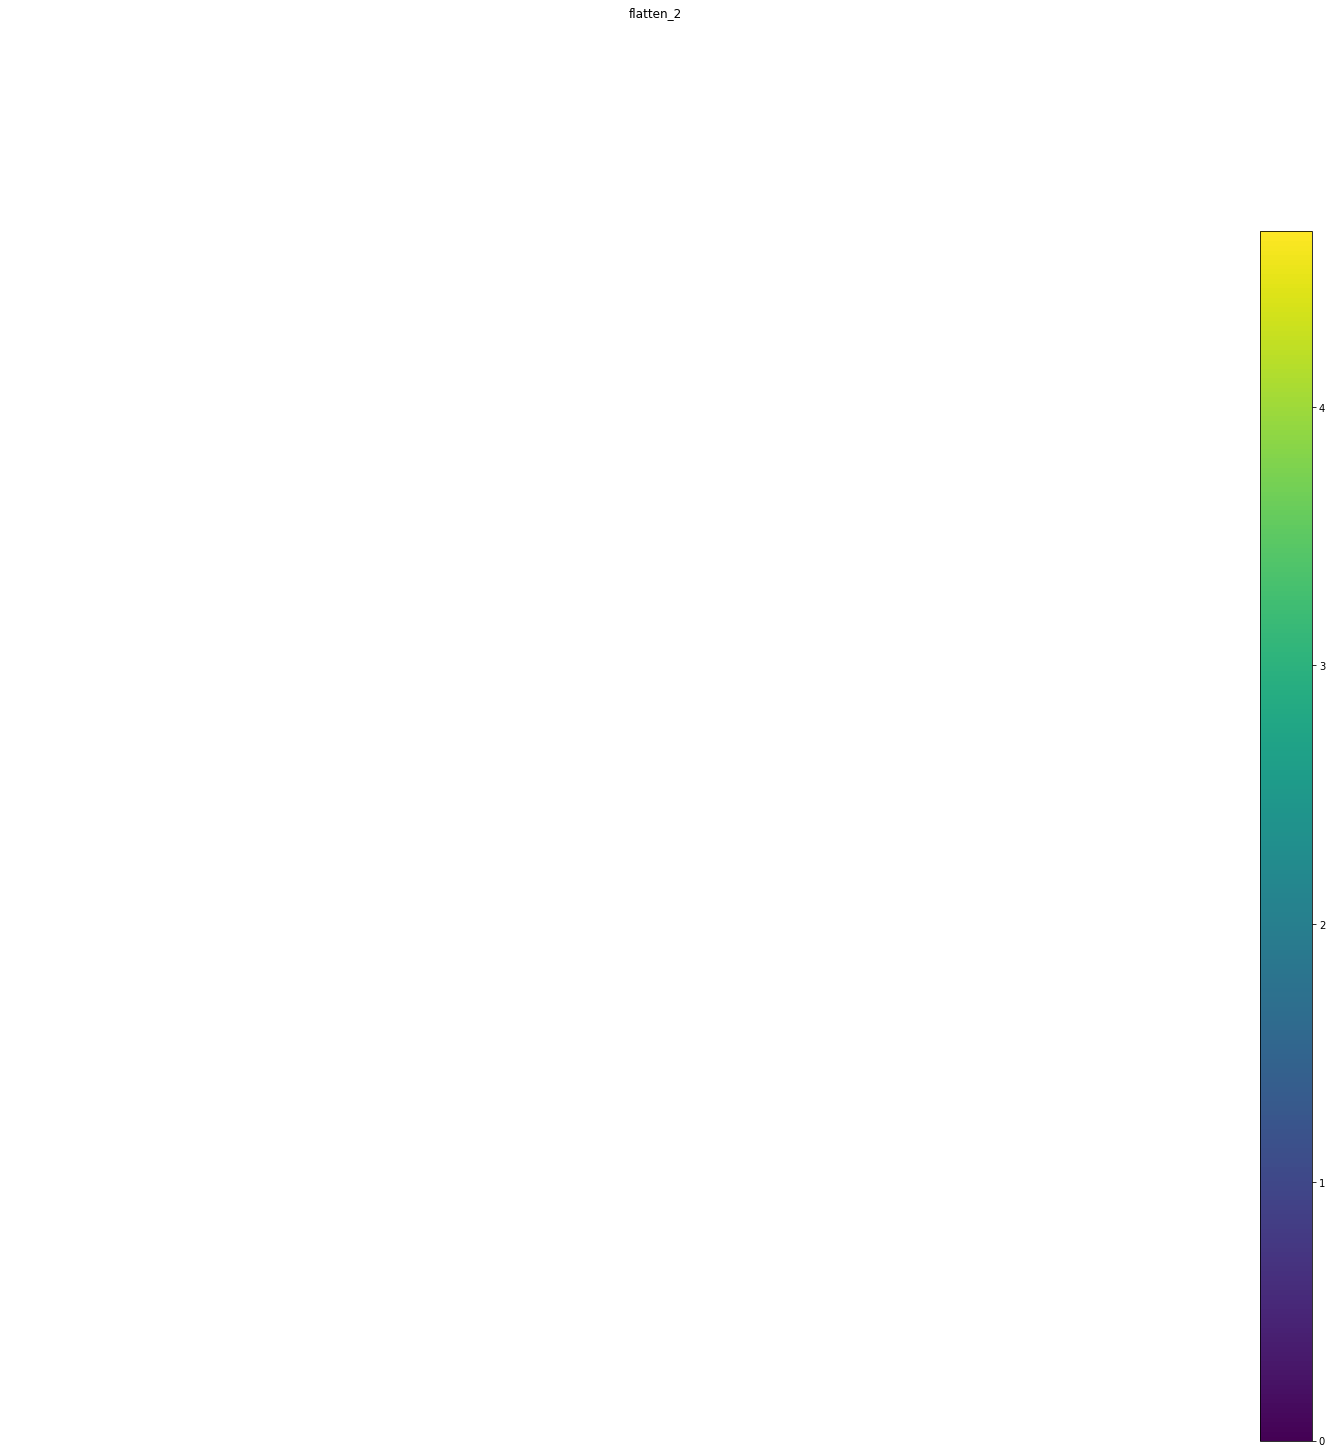

dropout_2 (1, 64512) 


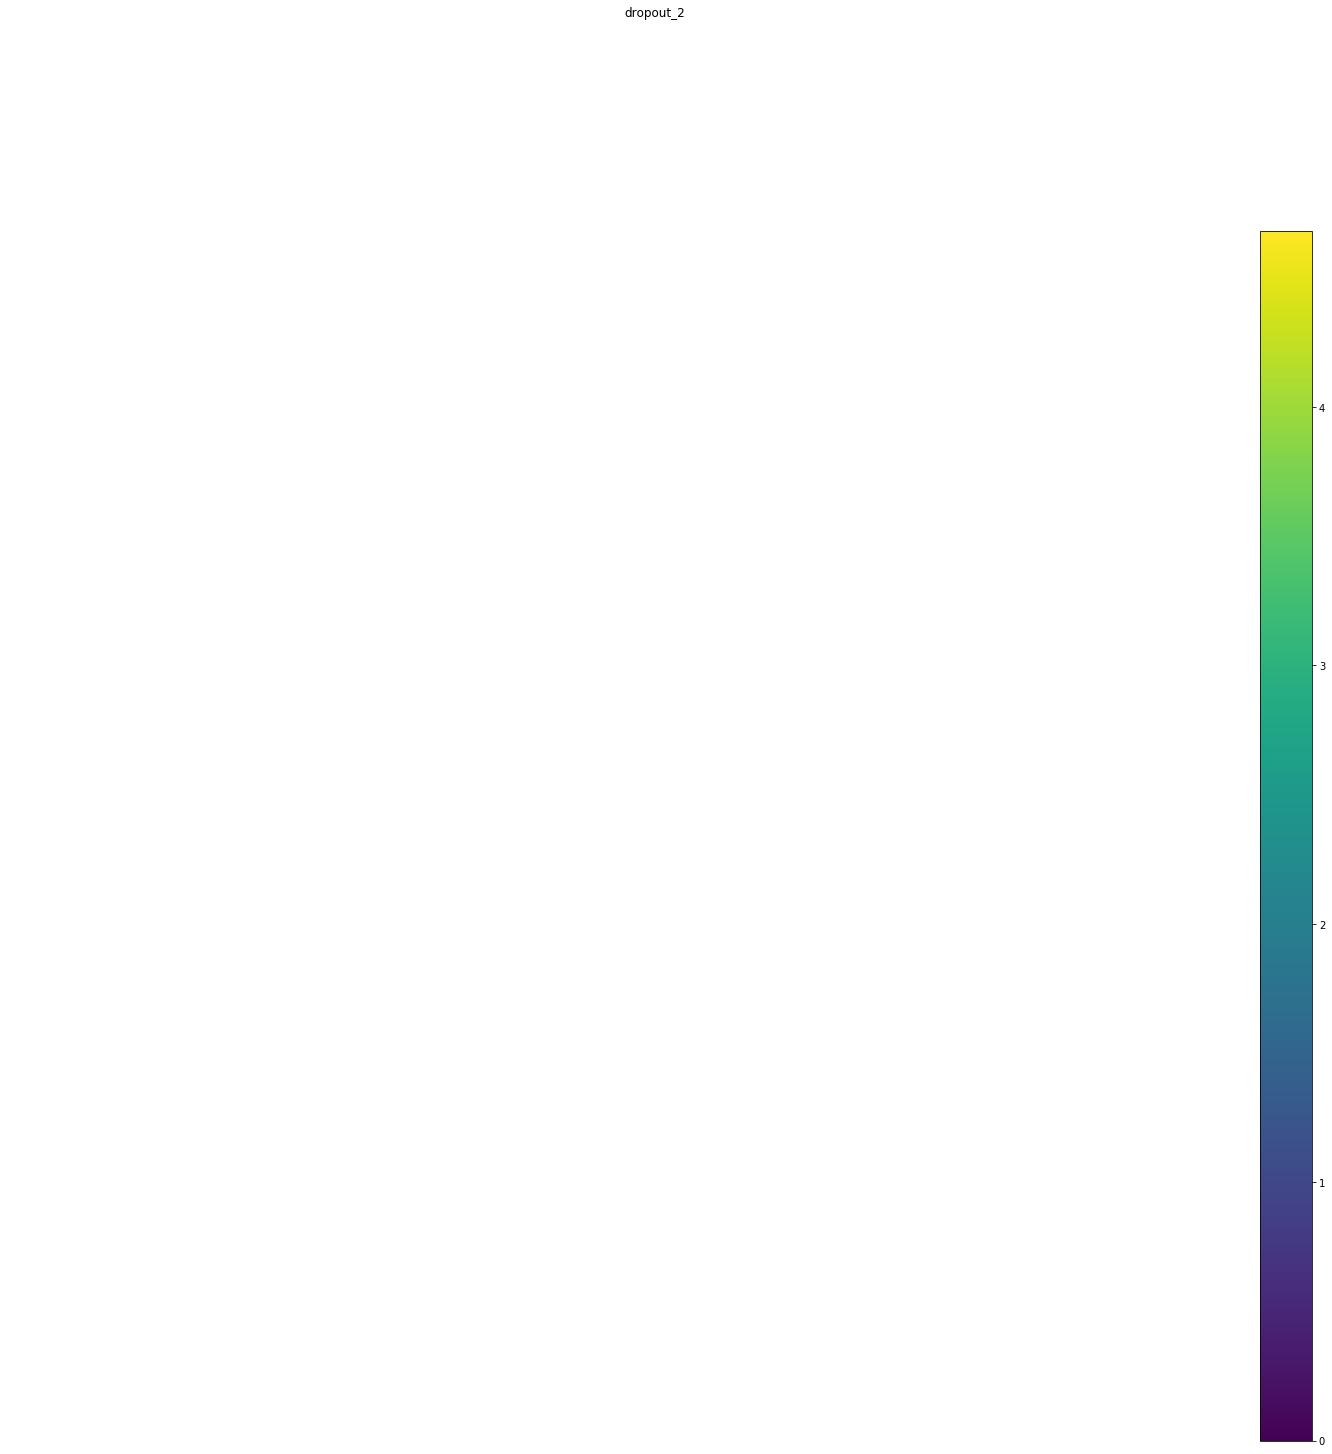

dense_4 (1, 128) 


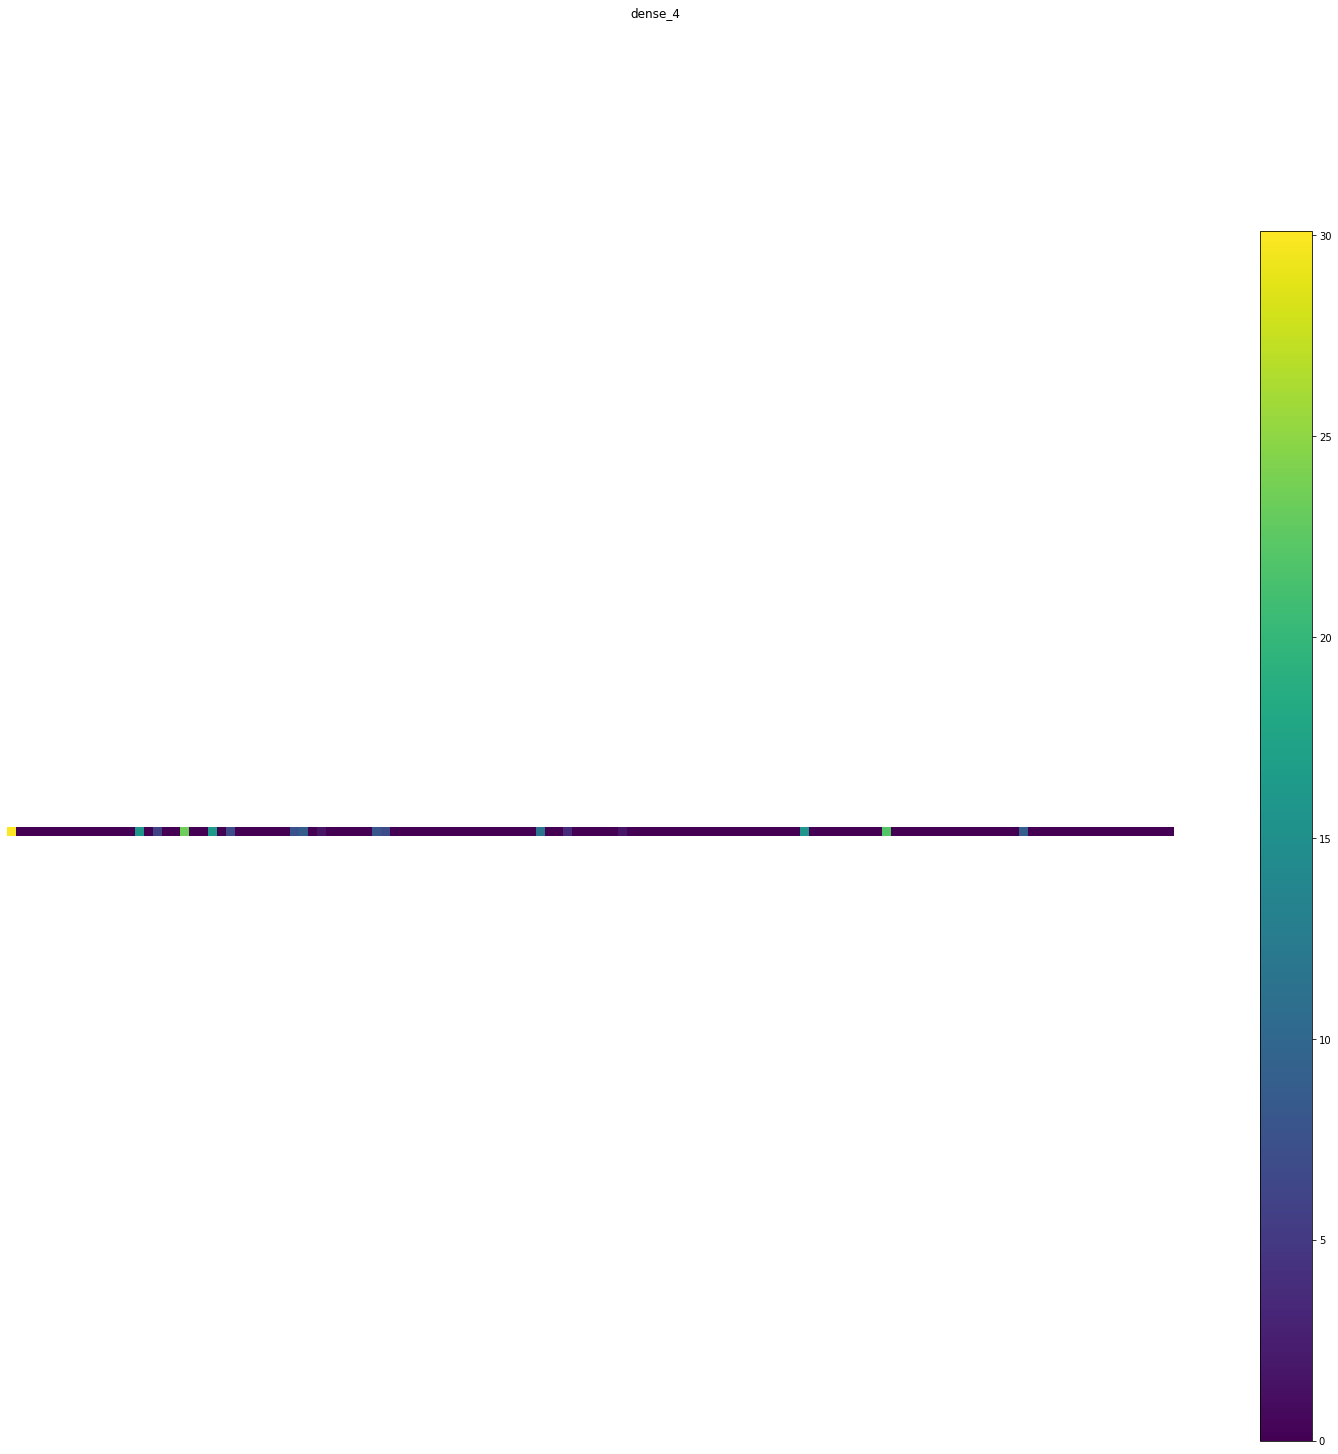

dense_1_2 (1, 128) 


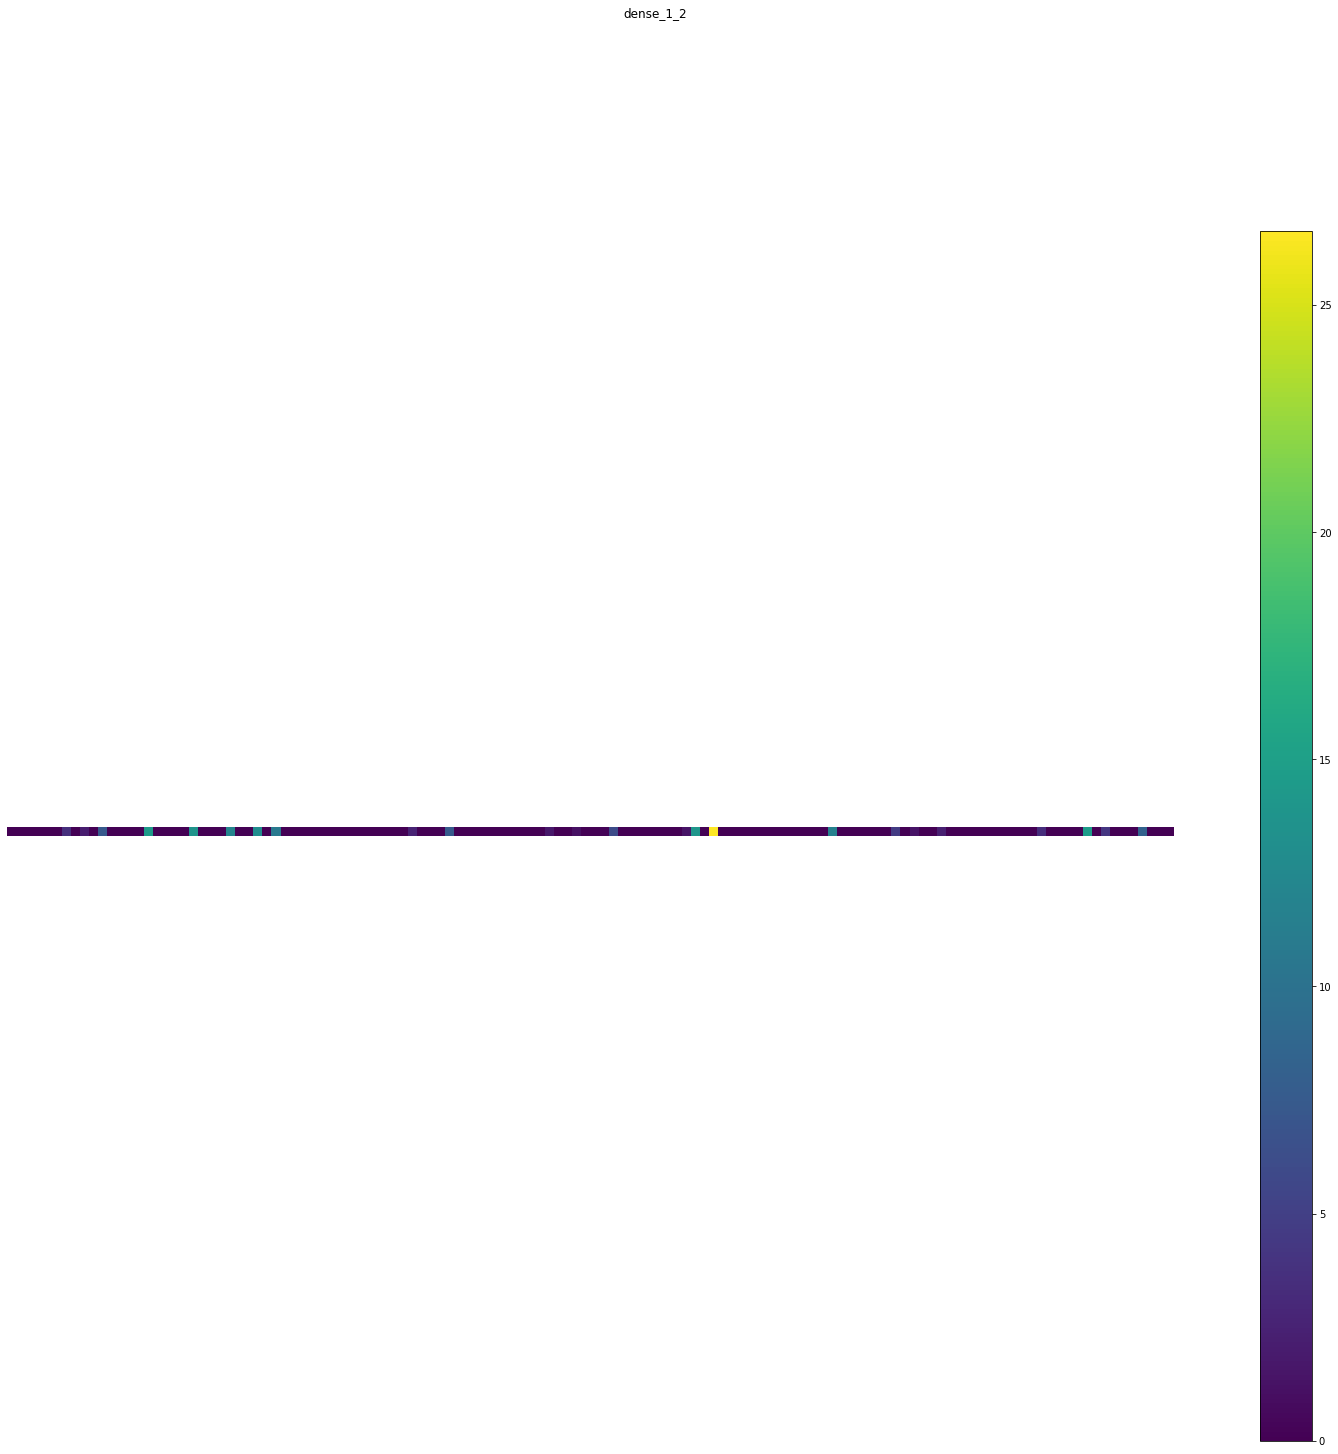

dense_2_2 (1, 7) 


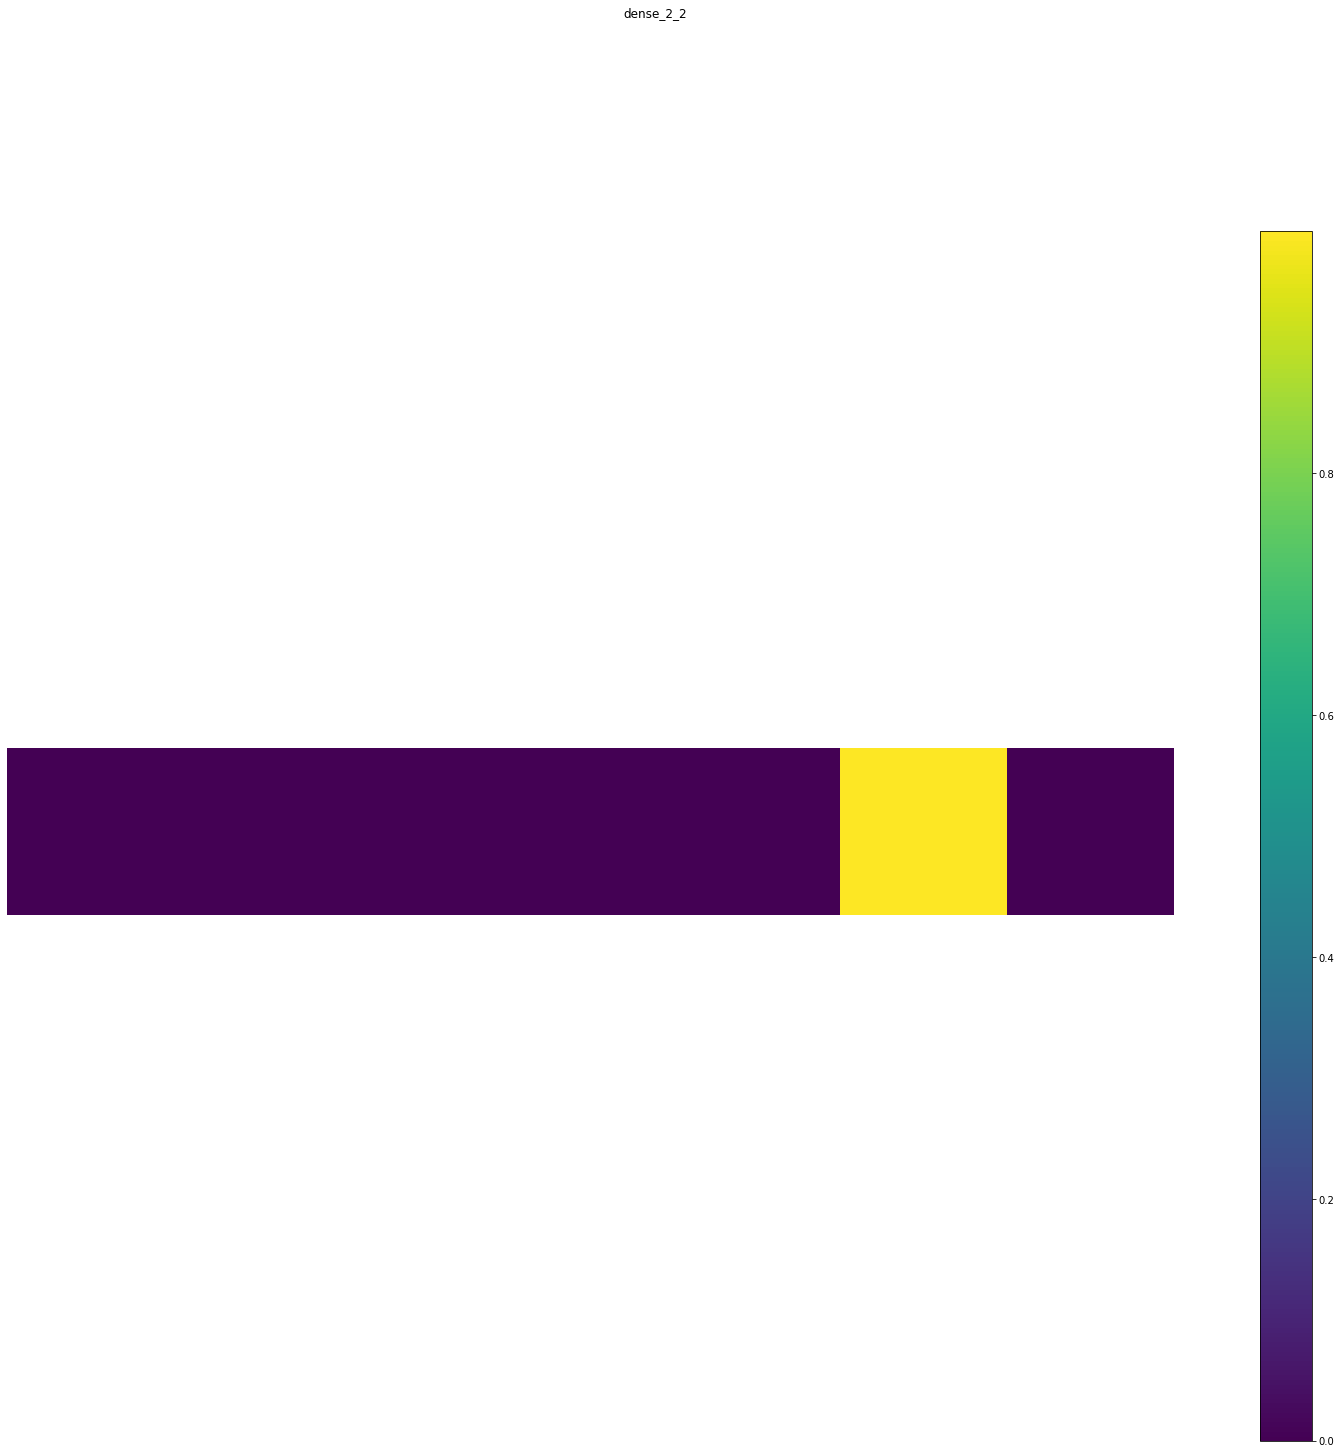

In [0]:
display_activations (activations, save=False)

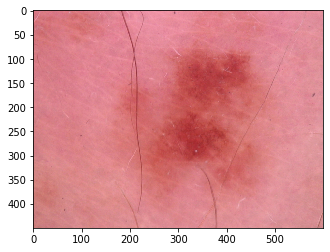

In [0]:
#image that the filters are working on
plt.imshow(imageList[1])